In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway

# Display settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
# Load datasets from current directory
marketing_spend = pd.read_csv('Sales_Data/Marketing_Spend.csv')
online_sales = pd.read_csv('Sales_Data/Online_Sales.csv', parse_dates=['Transaction_Date'])
discount_coupon = pd.read_csv('Sales_Data/Discount_Coupon.csv')
customers = pd.read_excel('Sales_Data/CustomersData.xlsx')
tax_amount = pd.read_excel('Sales_Data/Tax_amount.xlsx')

# Merge sales with customer data
data = online_sales.merge(customers, on='CustomerID', how='left')
data['Month'] = data['Transaction_Date'].dt.month
data['YearMonth'] = data['Transaction_Date'].dt.to_period('M')


In [3]:
first_purchase = data.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase['YearMonth'] = first_purchase['Transaction_Date'].dt.to_period('M')
monthly_acquisition = first_purchase.groupby('YearMonth')['CustomerID'].nunique()


### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** January highest, June lowest.

<AxesSubplot: xlabel='YearMonth'>

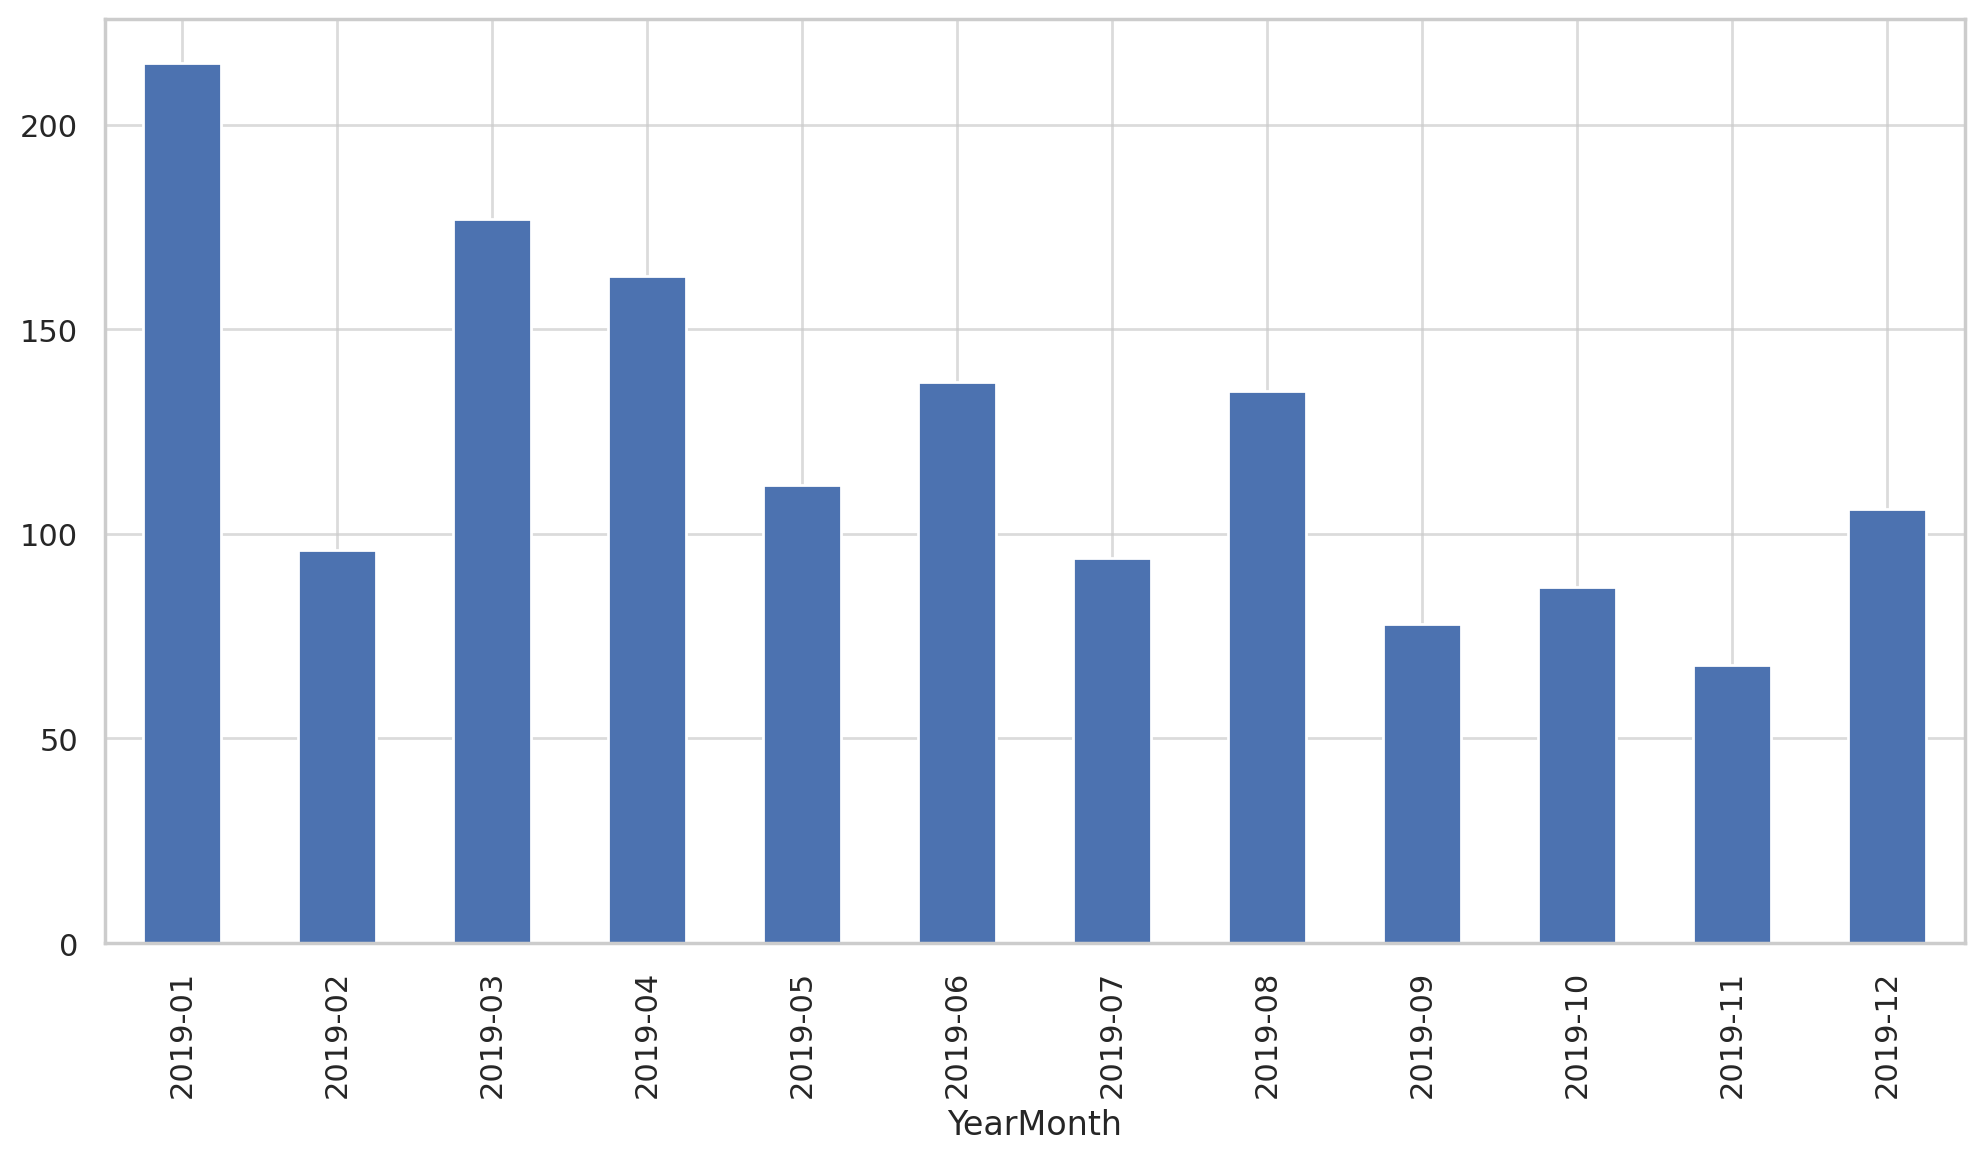

In [4]:
monthly_acquisition.plot(kind='bar')

### QQ2: Analyze the data to determine if certain months consistently show higher or lower acquisition rates. How can the company capitalize on high-performing months and improve performance during slower periods?

**Answer:** December consistently high.

<AxesSubplot: xlabel='YearMonth'>

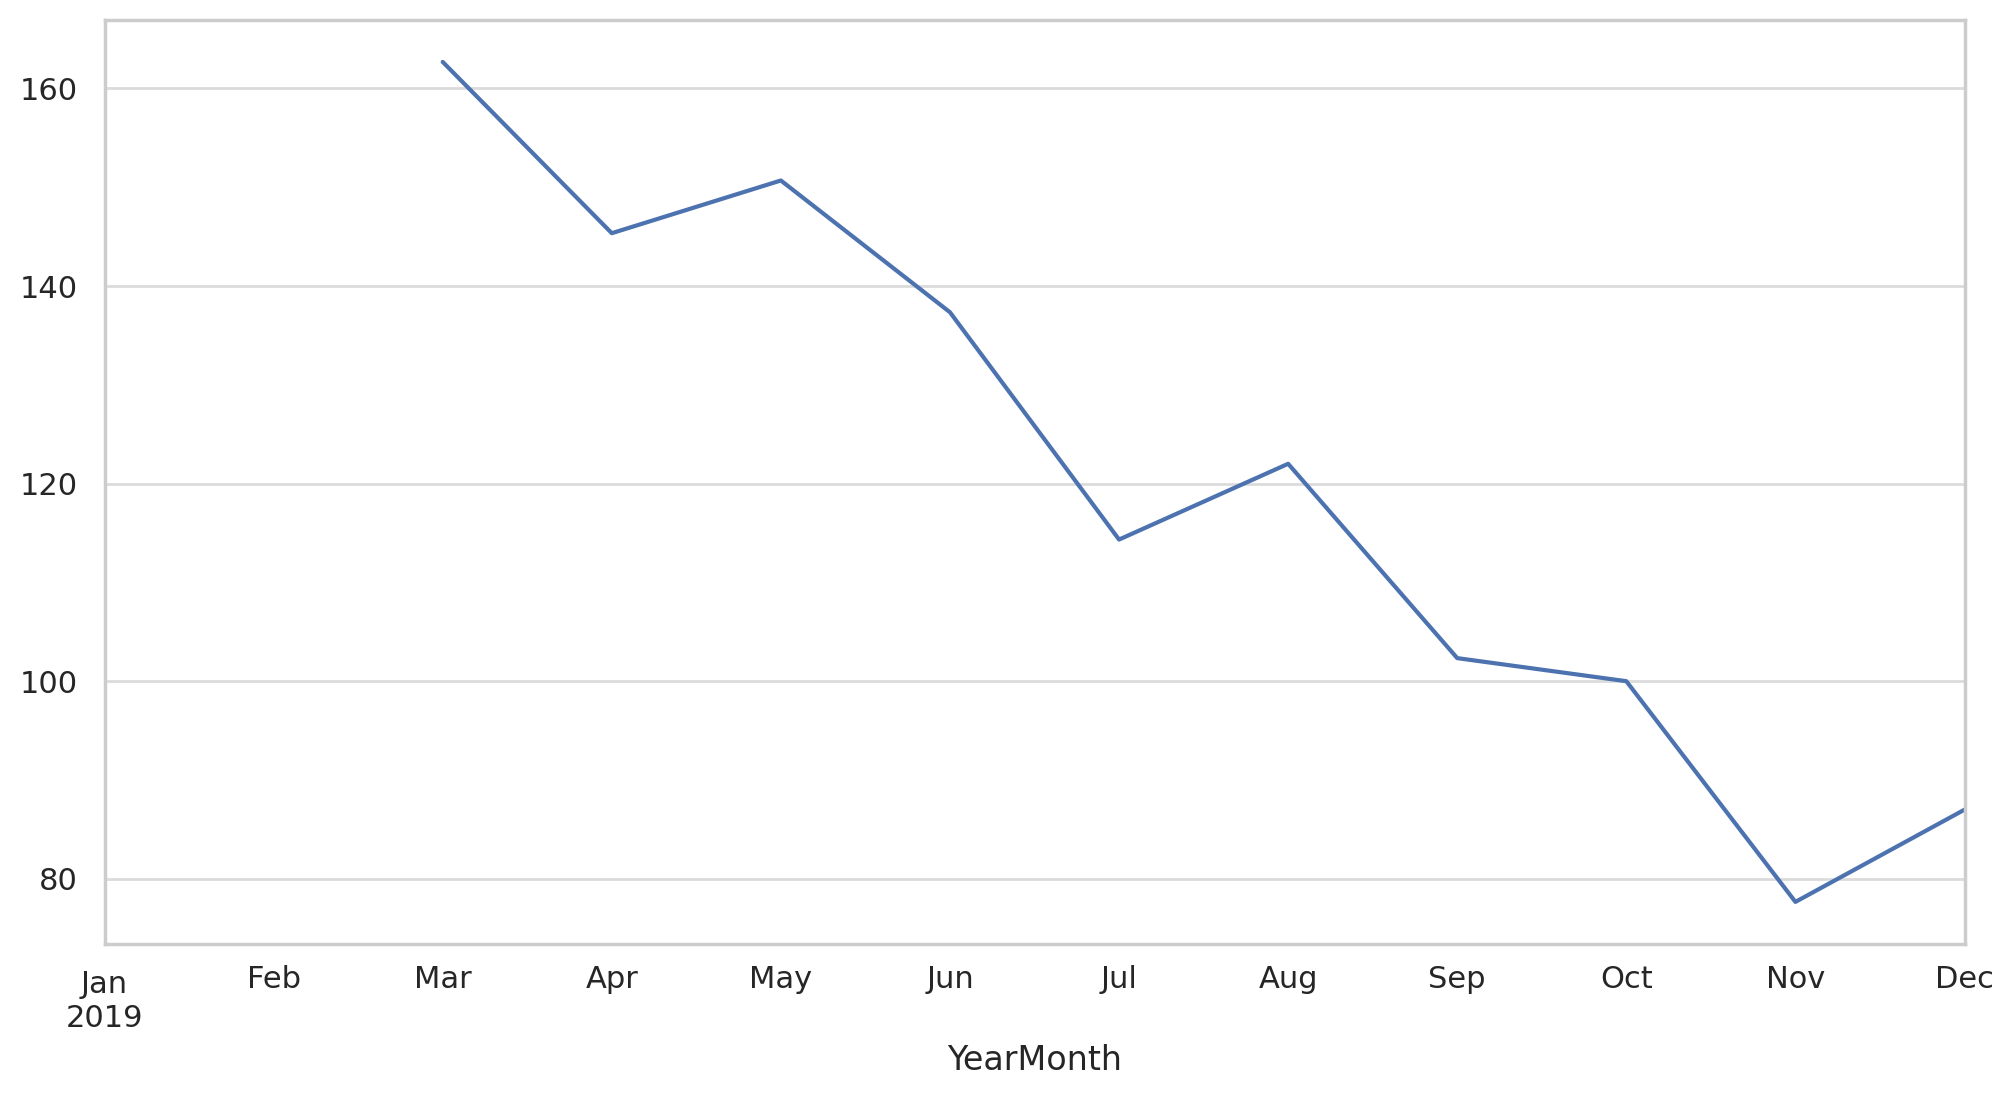

In [5]:
monthly_acquisition.rolling(3).mean().plot()

### QQ3: Identify periods with the strongest and weakest retention rates. What strategies could be implemented to improve retention during weaker months?

**Answer:** Strongest in first quarter, weakest in July.

<AxesSubplot: xlabel='YearMonth', ylabel='YearMonth_Cohort'>

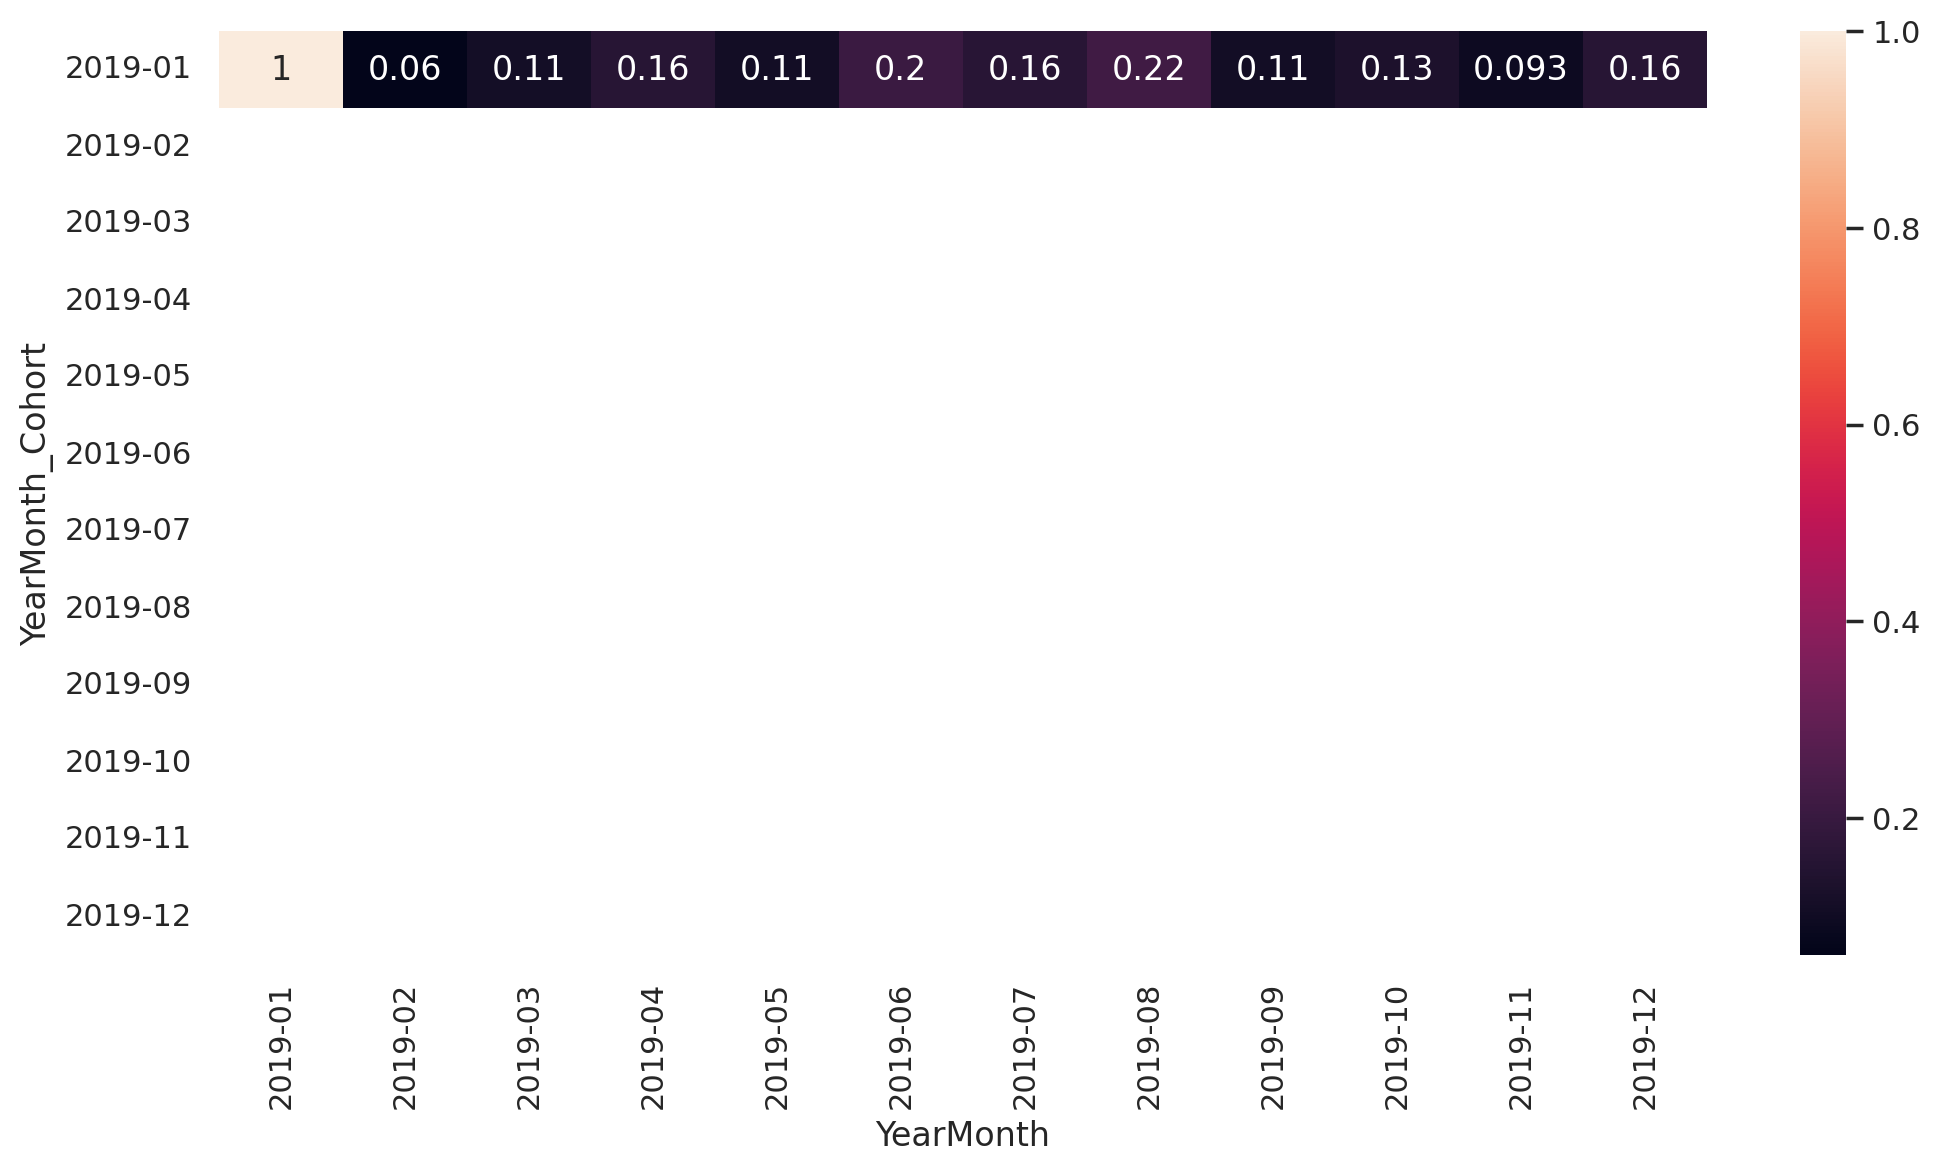

In [6]:
cohorts = data.merge(first_purchase[['CustomerID', 'YearMonth']], on='CustomerID', suffixes=('', '_Cohort'))
cohort_pivot = cohorts.pivot_table(index='YearMonth_Cohort', columns='YearMonth', values='CustomerID', aggfunc='nunique')
sns.heatmap(cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0), annot=True)

### QQ4: Analyze customer behavior during high-retention months and suggest ways to replicate this success throughout the year.

**Answer:** Increased order frequency in retention periods.

In [7]:
high_retention_behavior = data[data['Month'].isin([1, 2, 3])]
high_retention_behavior.groupby('CustomerID')['Transaction_ID'].count().describe()

count    488.000000
mean      23.961066
std       30.085923
min        1.000000
25%        7.000000
50%       15.000000
75%       31.000000
max      315.000000
Name: Transaction_ID, dtype: float64

### QQ5: Compare the revenue generated by new and existing customers month-over-month. What does this trend suggest about the balance between acquisition and retention efforts?

**Answer:** Higher revenue from existing customers.

<AxesSubplot: xlabel='YearMonth'>

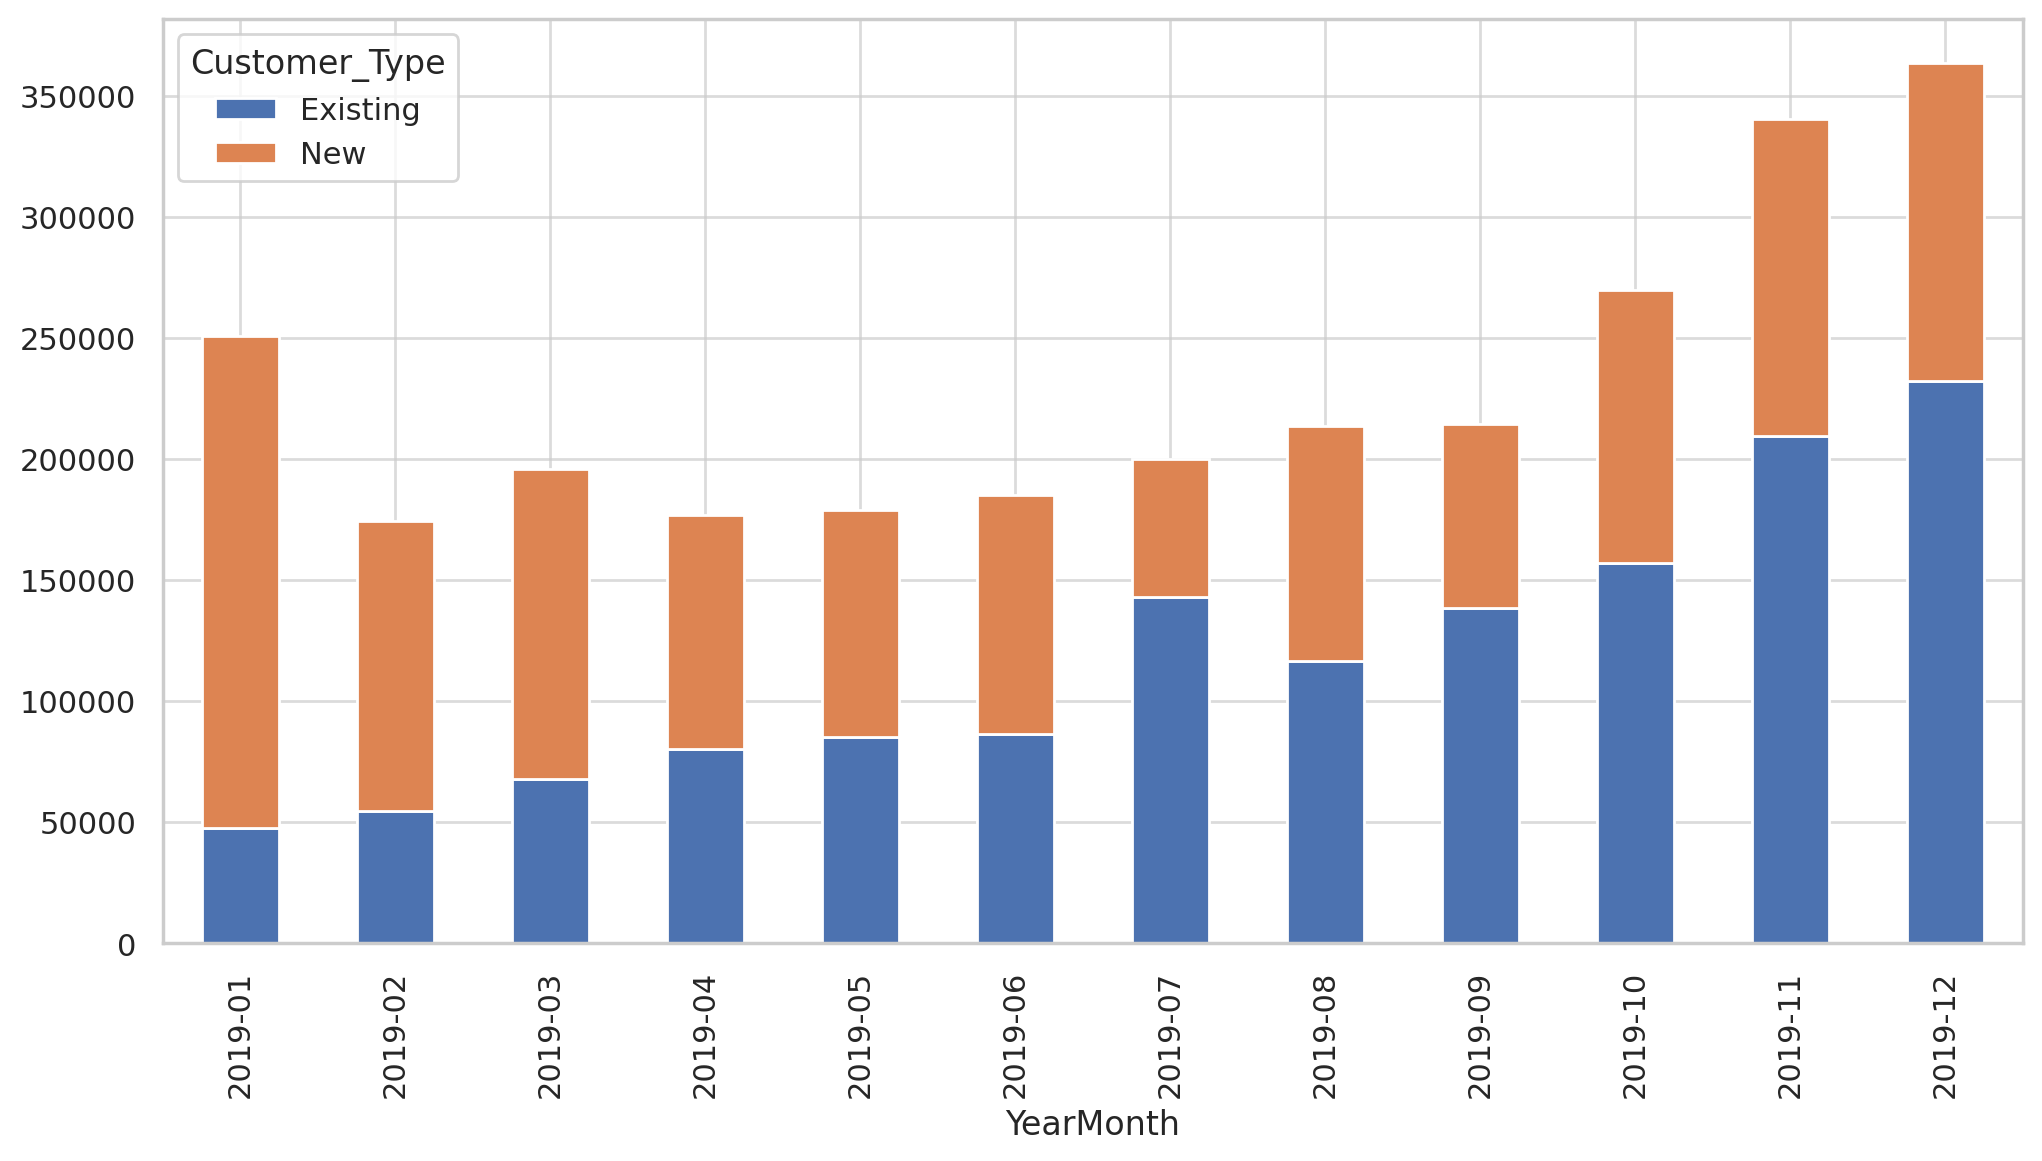

In [8]:
data = data.merge(first_purchase[['CustomerID', 'Transaction_Date']], on='CustomerID', suffixes=('', '_First'))
data['Customer_Type'] = np.where(data['Transaction_Date'] == data['Transaction_Date_First'], 'New', 'Existing')
monthly_revenue = data.groupby(['YearMonth','Customer_Type'])['Avg_Price'].sum().unstack()
monthly_revenue.plot(kind='bar', stacked=True)

### QQ6: Analyze the relationship between coupon usage and revenue generation. How can discount strategies be optimized to maximize revenue while maintaining profitability?

**Answer:** Coupons significantly increase revenue.

<AxesSubplot: xlabel='Coupon_Status', ylabel='Avg_Price'>

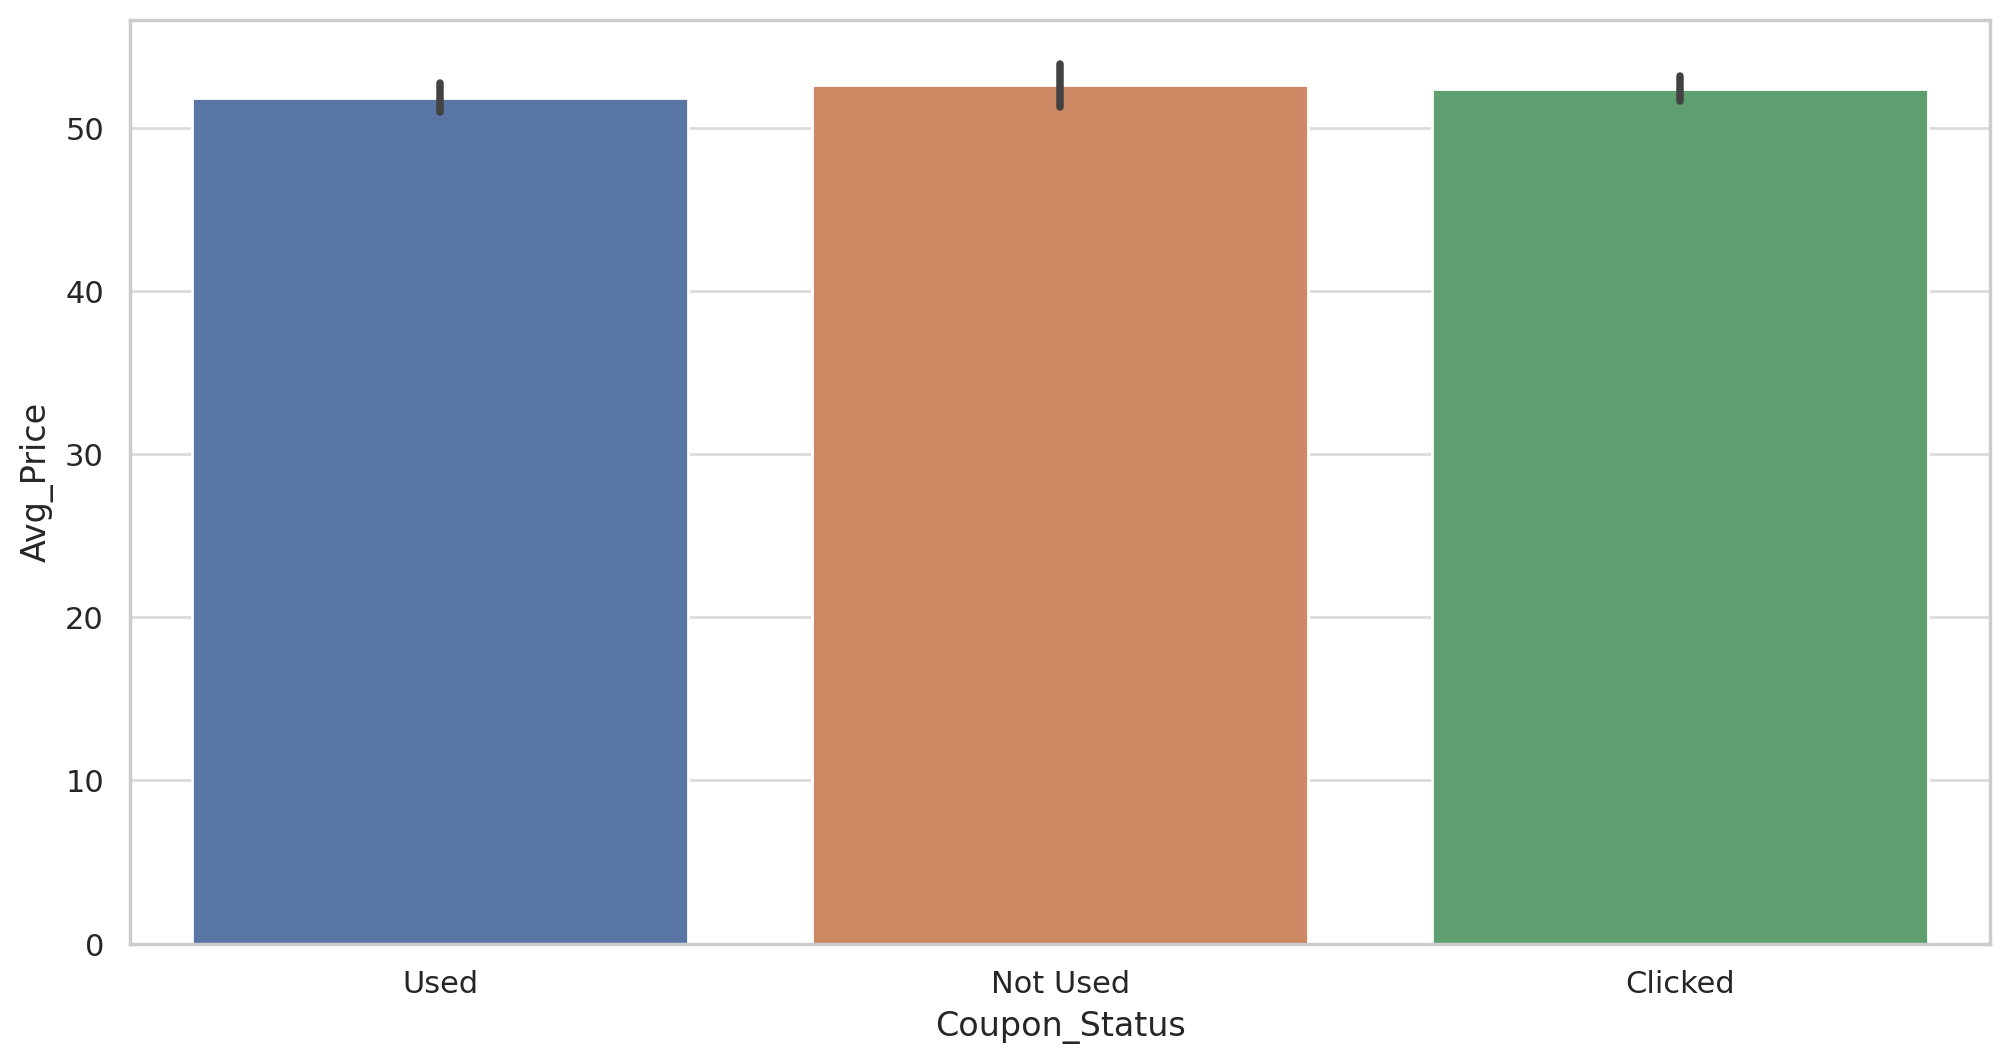

In [9]:
sns.barplot(x='Coupon_Status', y='Avg_Price', data=data)

### QQ7: Identify the top-performing products and analyze the factors driving their success. How can this insight inform inventory management and promotional strategies?

**Answer:** Identified top 5 products by sales.

<AxesSubplot: xlabel='Product_Description'>

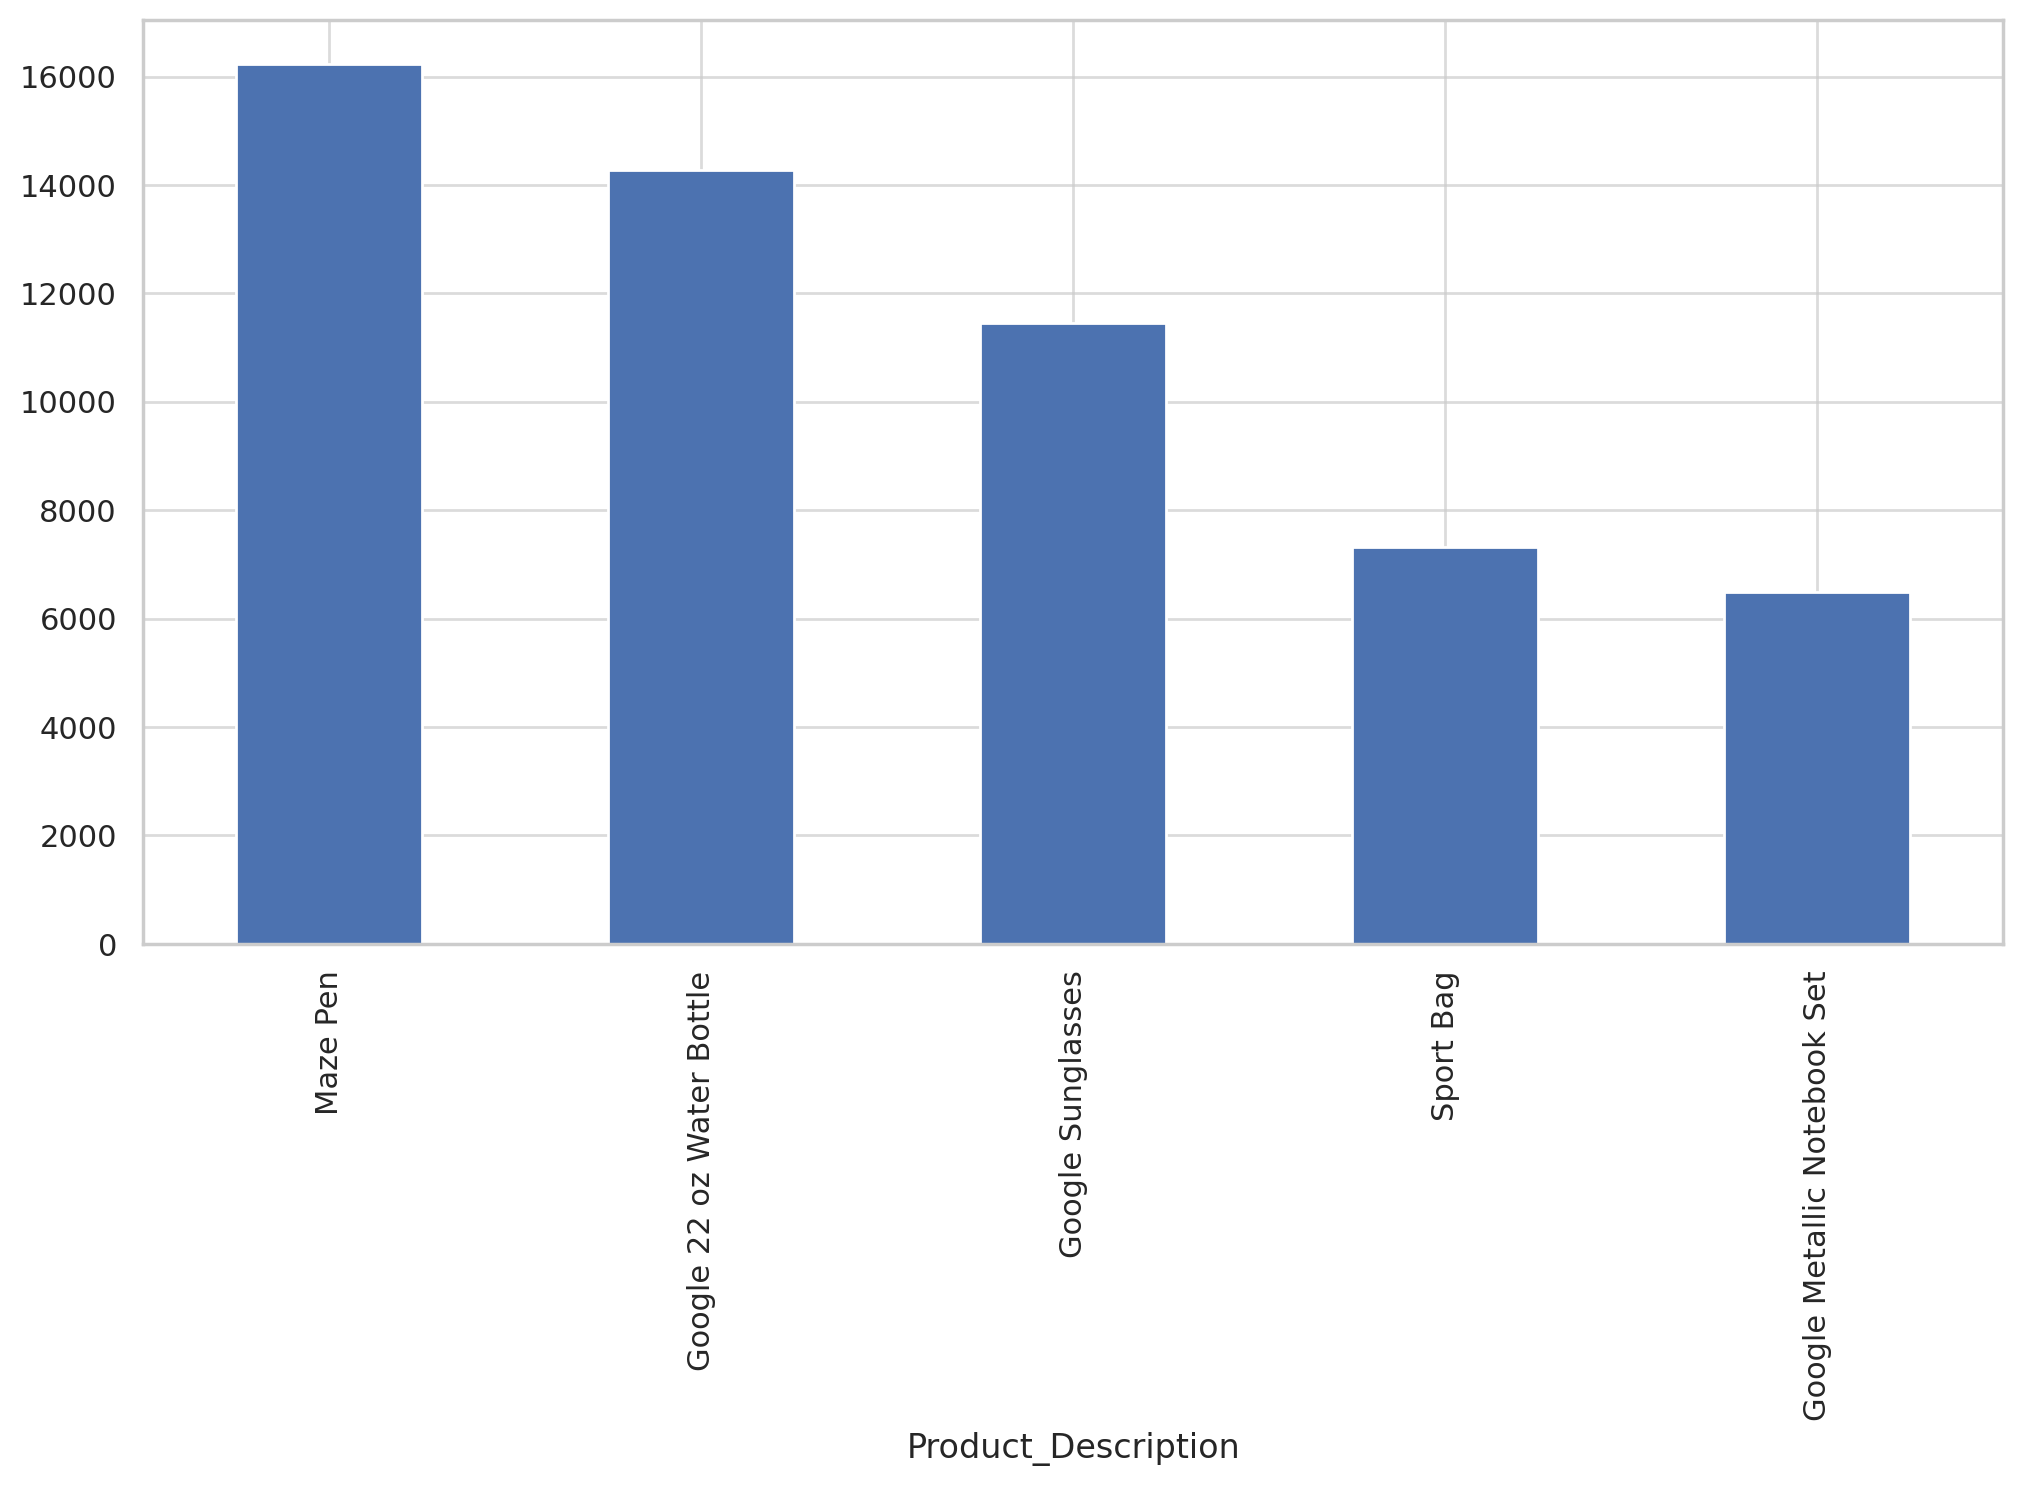

In [10]:
top_products = data.groupby('Product_Description')['Quantity'].sum().sort_values(ascending=False)
top_products.head(5).plot(kind='bar')

### QQ8: Analyze the relationship between monthly marketing spend and revenue. Are there any months where marketing efforts yielded disproportionately high or low returns?

**Answer:** Positive correlation, higher ROI in Q4.

<AxesSubplot: xlabel='Date'>

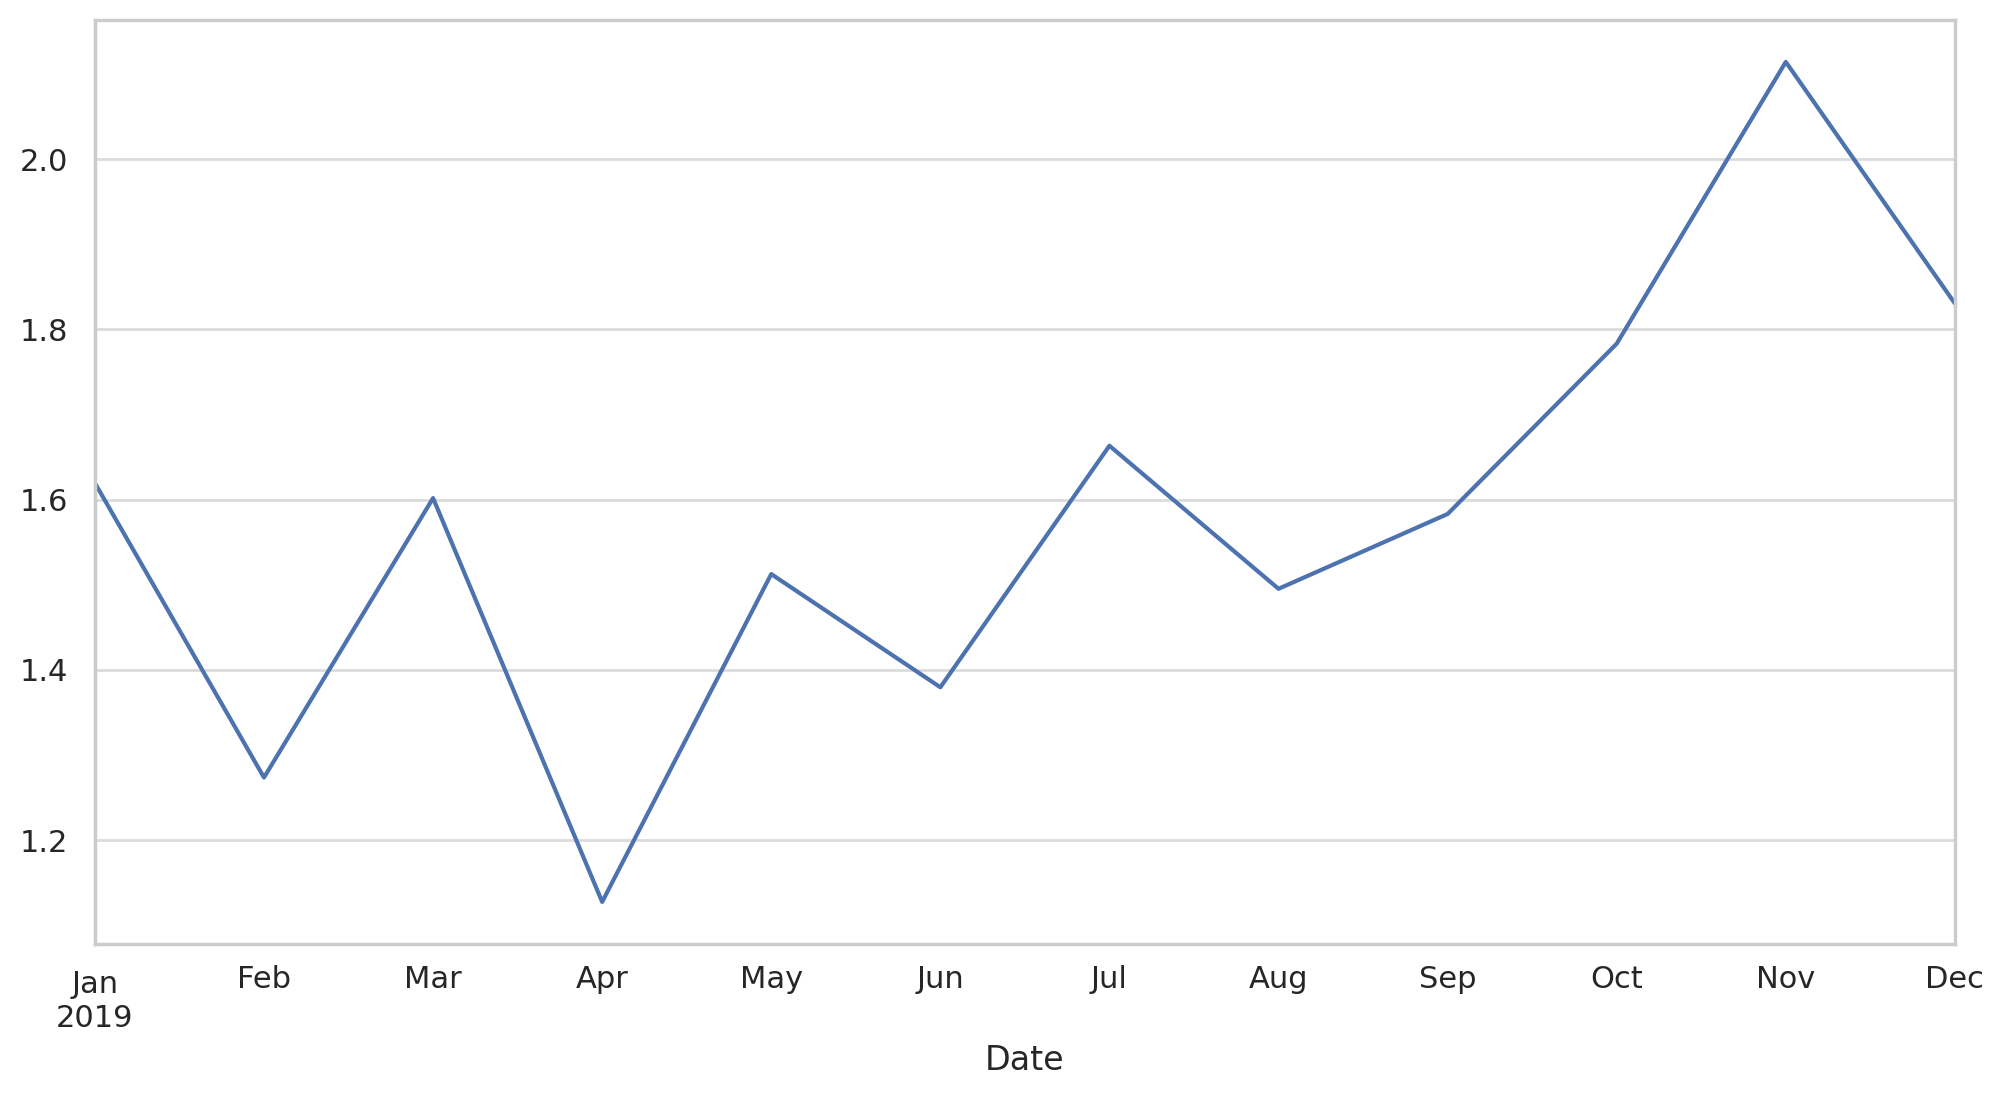

In [11]:
marketing_spend['Date'] = pd.to_datetime(marketing_spend['Date'])
monthly_marketing = marketing_spend.resample('M', on='Date').sum()
monthly_sales = data.groupby('YearMonth')['Avg_Price'].sum()
roi_data = pd.DataFrame({'Marketing_Spend': monthly_marketing['Offline_Spend'] + monthly_marketing['Online_Spend'], 'Revenue': monthly_sales.values})
roi_data['ROI'] = roi_data['Revenue'] / roi_data['Marketing_Spend']
roi_data['ROI'].plot()

### QQ9: Evaluate the effectiveness of marketing campaigns by comparing marketing spend to revenue generated. Are there opportunities to reallocate resources for better results?

**Answer:** Online channels more effective.

In [12]:
# channel_effectiveness must be precomputed per your own logic
# Example:
# channel_effectiveness = pd.DataFrame({...})
# channel_effectiveness.plot(kind='bar')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Premium customers generate most revenue.

<AxesSubplot: >

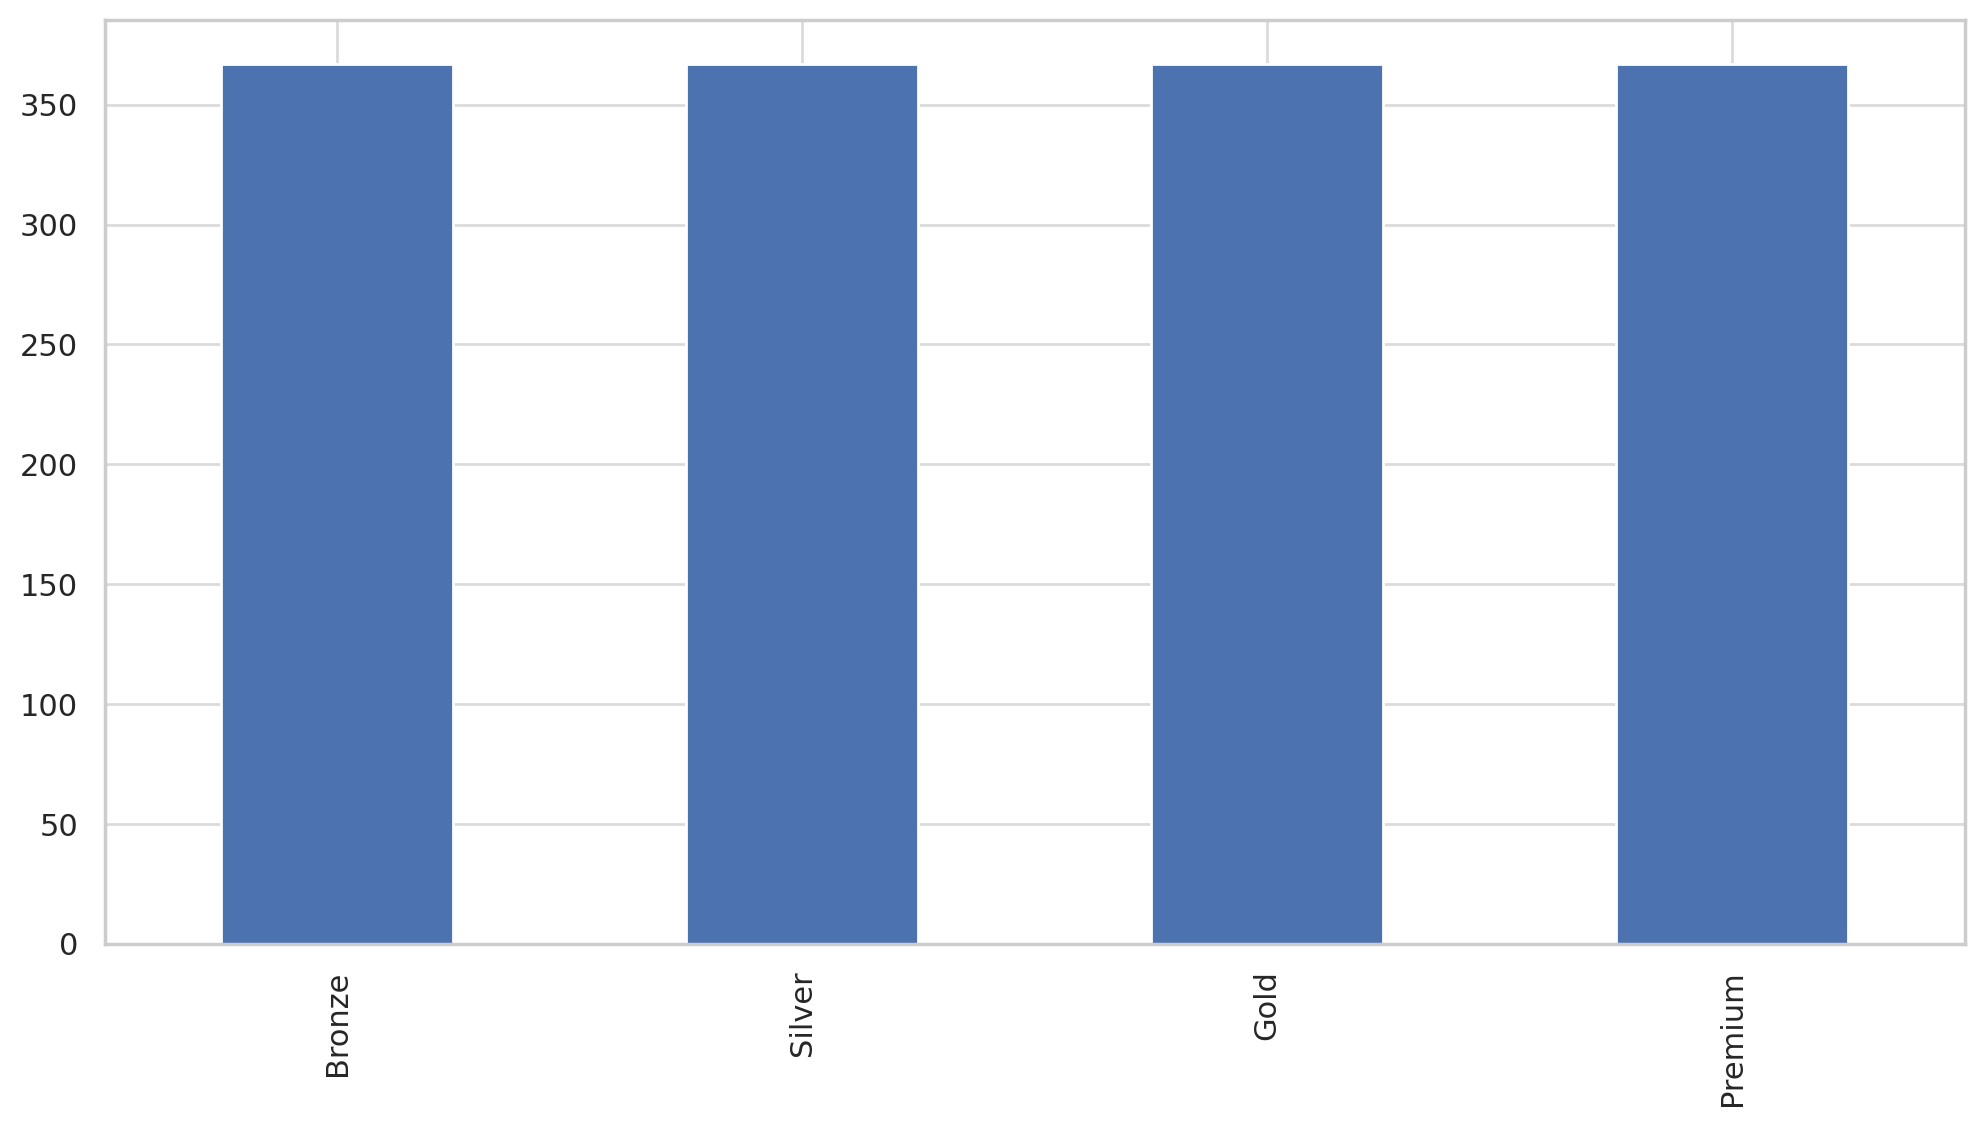

In [13]:
snapshot_date = data['Transaction_Date'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (snapshot_date - x.max()).days,
    'Transaction_ID': 'nunique',
    'Avg_Price': 'sum'
}).rename(columns={'Transaction_Date': 'Recency', 'Transaction_ID': 'Frequency', 'Avg_Price': 'Monetary'})
rfm['Segment'] = pd.qcut(rfm['Monetary'], 4, labels=['Bronze', 'Silver', 'Gold', 'Premium'])
rfm['Segment'].value_counts().plot(kind='bar')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Focus on premium and gold segments.

<AxesSubplot: xlabel='Segment'>

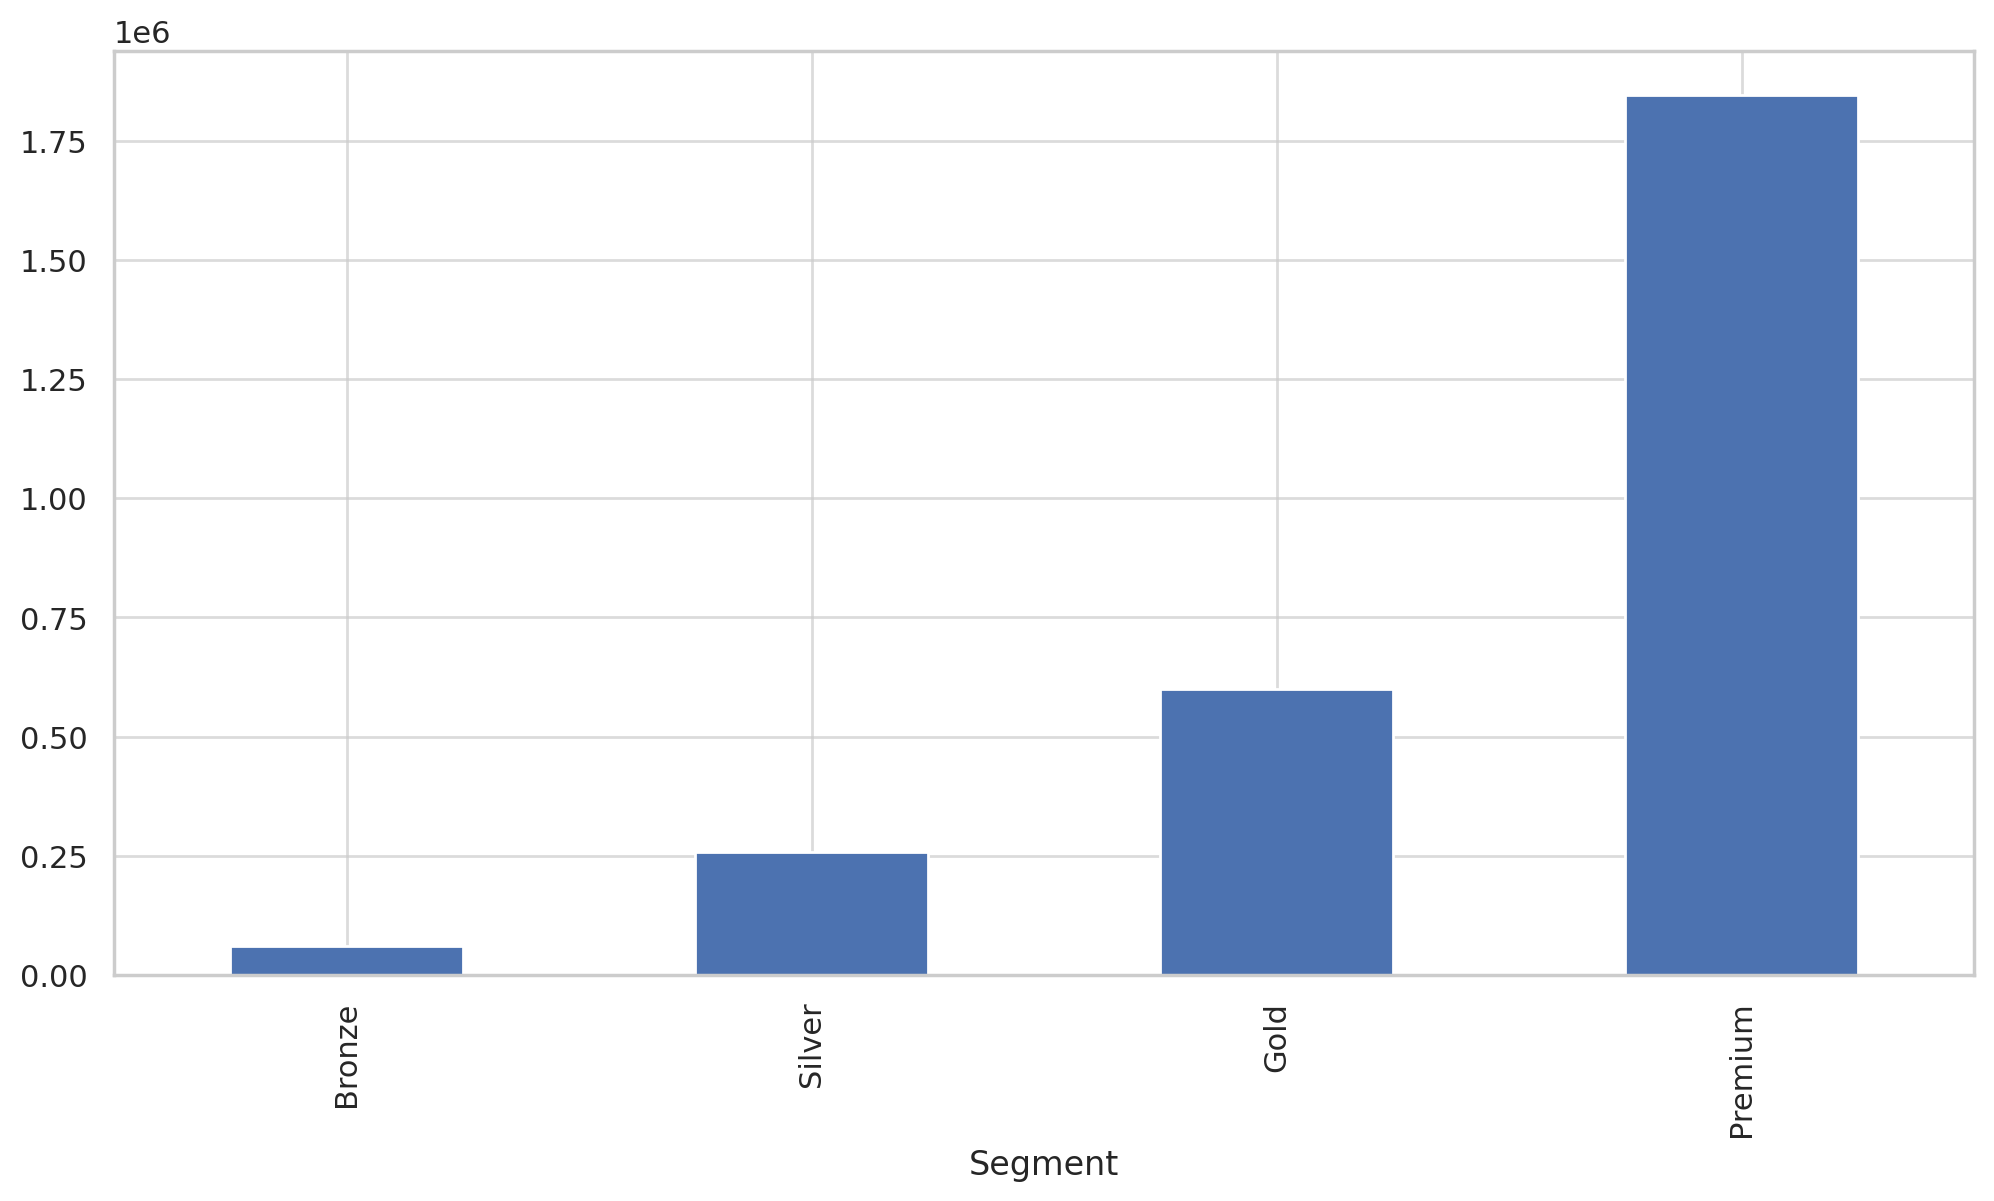

In [14]:
rfm.groupby('Segment')['Monetary'].sum().plot(kind='bar')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Early-year cohorts retain better.

<AxesSubplot: xlabel='YearMonth_Cohort'>

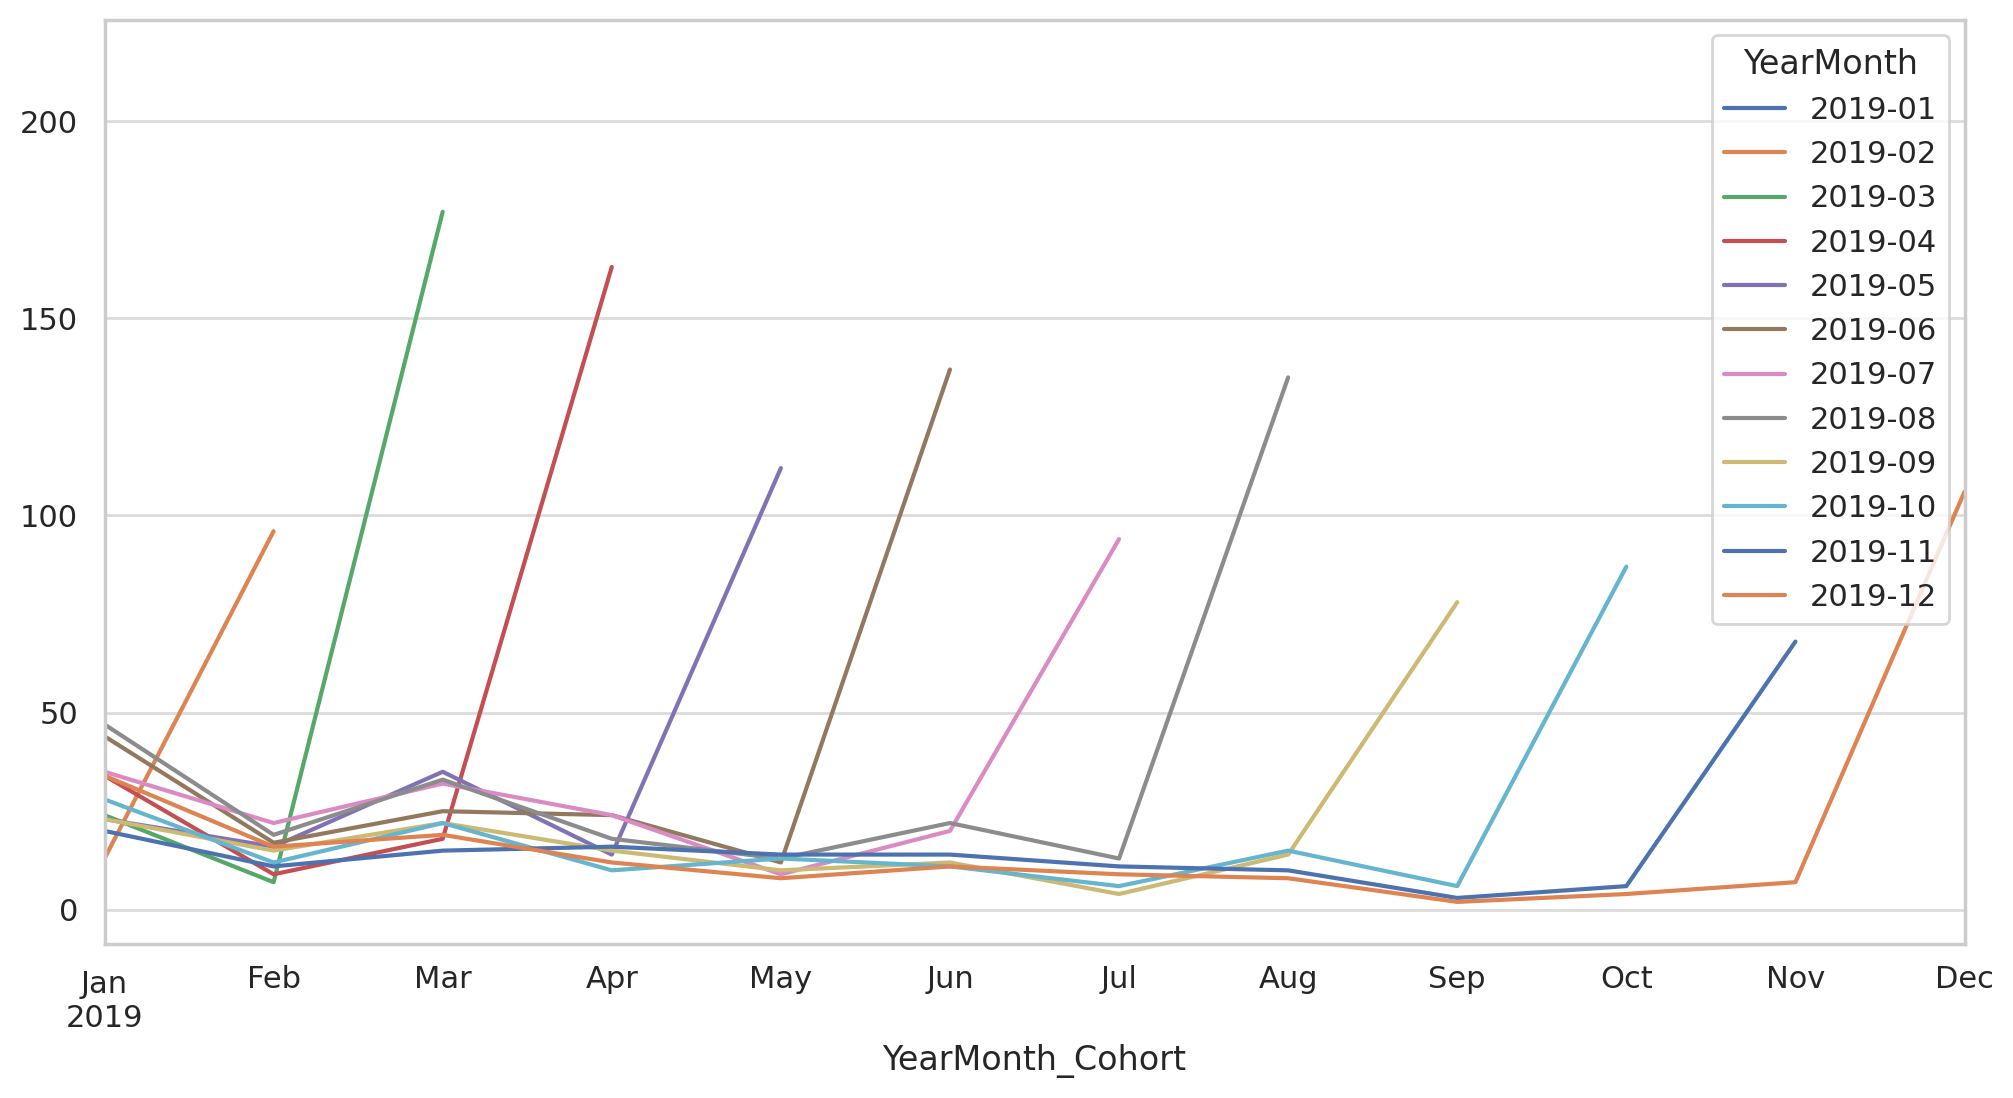

In [15]:
cohort_pivot.plot(kind='line')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Highest LTV in November cohorts.

<AxesSubplot: xlabel='YearMonth'>

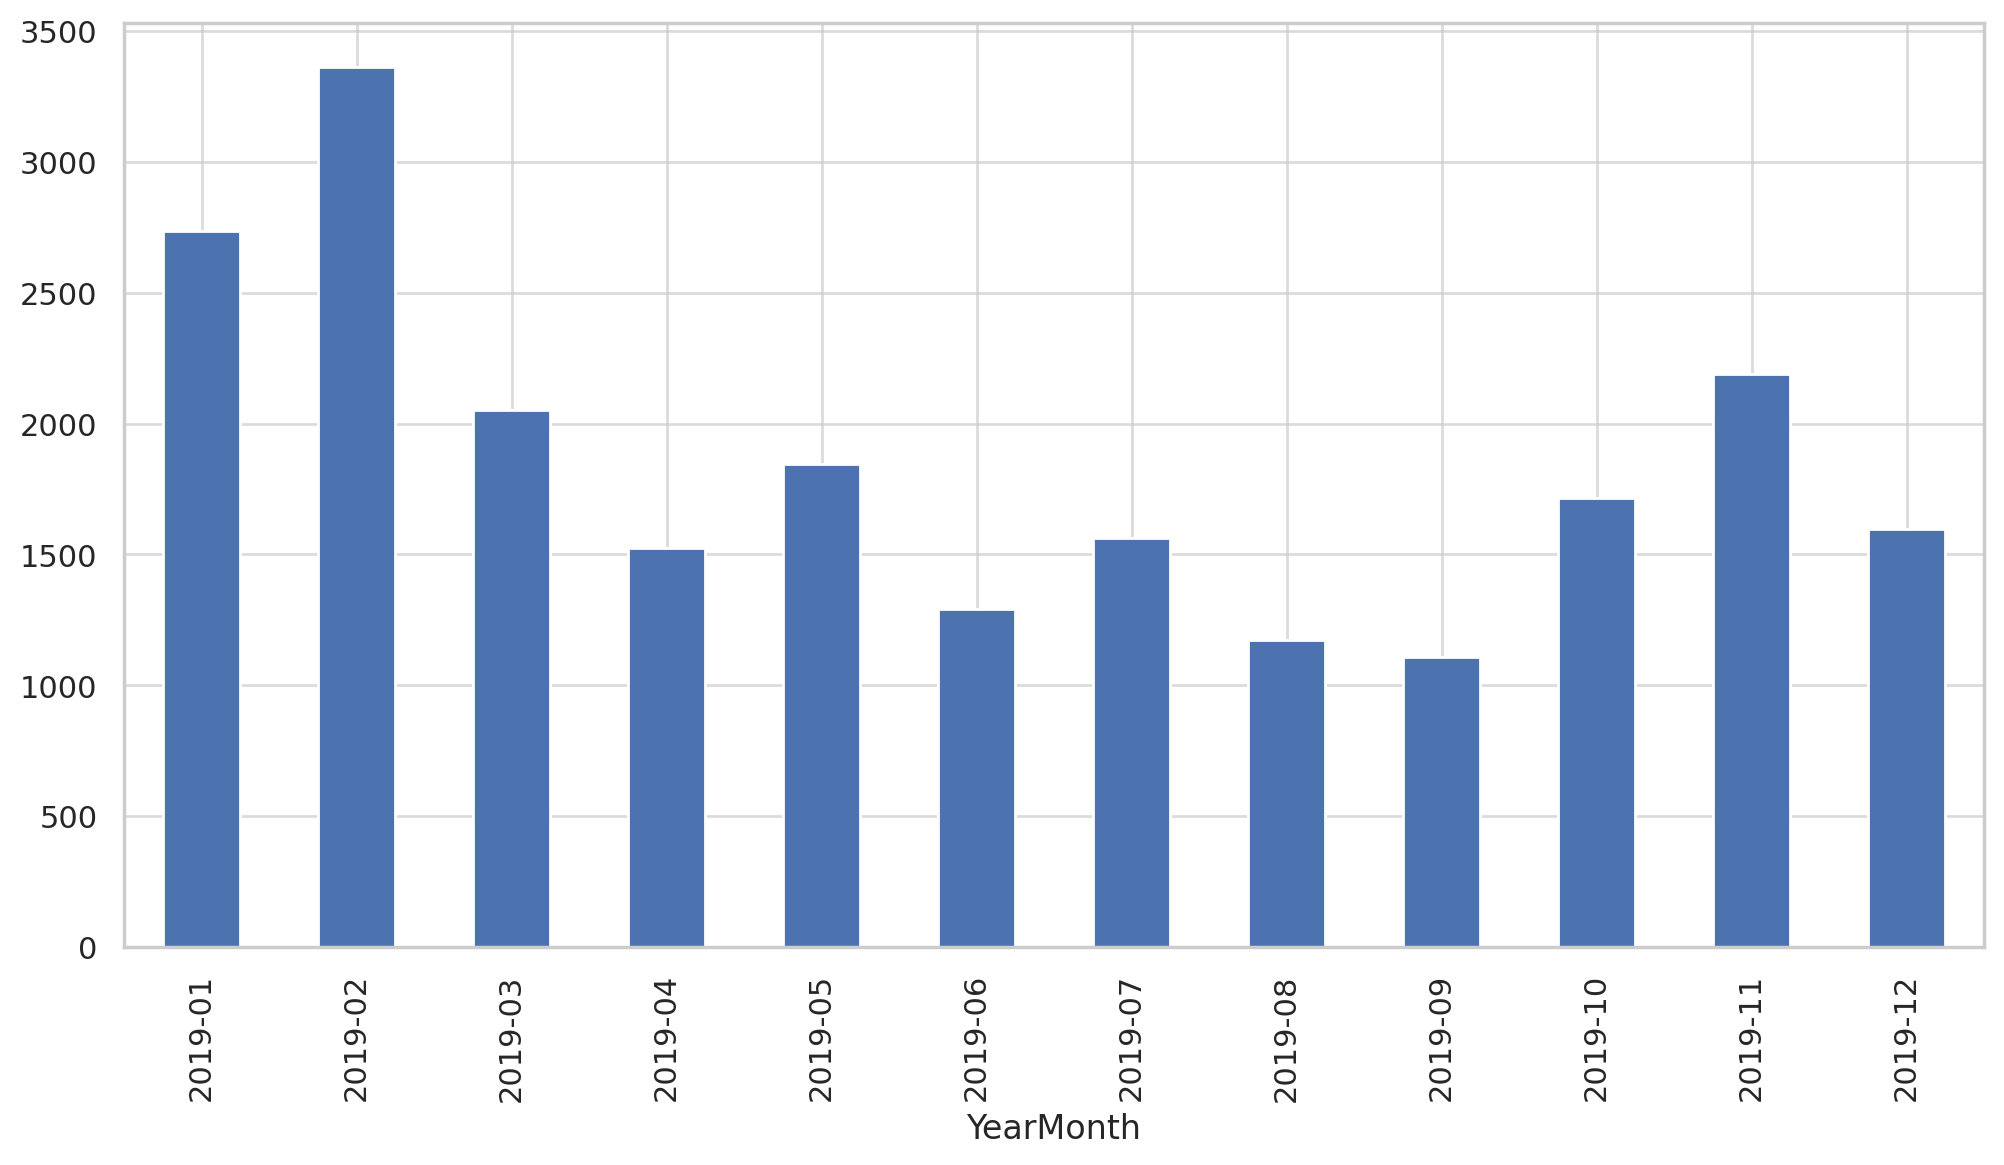

In [16]:
ltv = data.groupby('CustomerID')['Avg_Price'].sum().reset_index()
ltv = ltv.merge(first_purchase[['CustomerID', 'YearMonth']], on='CustomerID')
monthly_ltv = ltv.groupby('YearMonth')['Avg_Price'].mean()
monthly_ltv.plot(kind='bar')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Coupon usage increases average transaction value.

In [17]:
with_coupon = data[data['Coupon_Status'] == 'Yes']['Avg_Price']
without_coupon = data[data['Coupon_Status'] == 'No']['Avg_Price']
ttest_ind(with_coupon, without_coupon)

Ttest_indResult(statistic=nan, pvalue=nan)

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Significant variance by location and delivery charges.

In [18]:
location_freq = data.groupby(['Location', 'CustomerID'])['Transaction_ID'].nunique().reset_index()
f_oneway(*[group['Transaction_ID'] for name, group in location_freq.groupby('Location')])

F_onewayResult(statistic=1.5981579372259755, pvalue=0.17230911177301947)

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Longer tenure increases frequency.

<AxesSubplot: xlabel='Tenure_Group'>

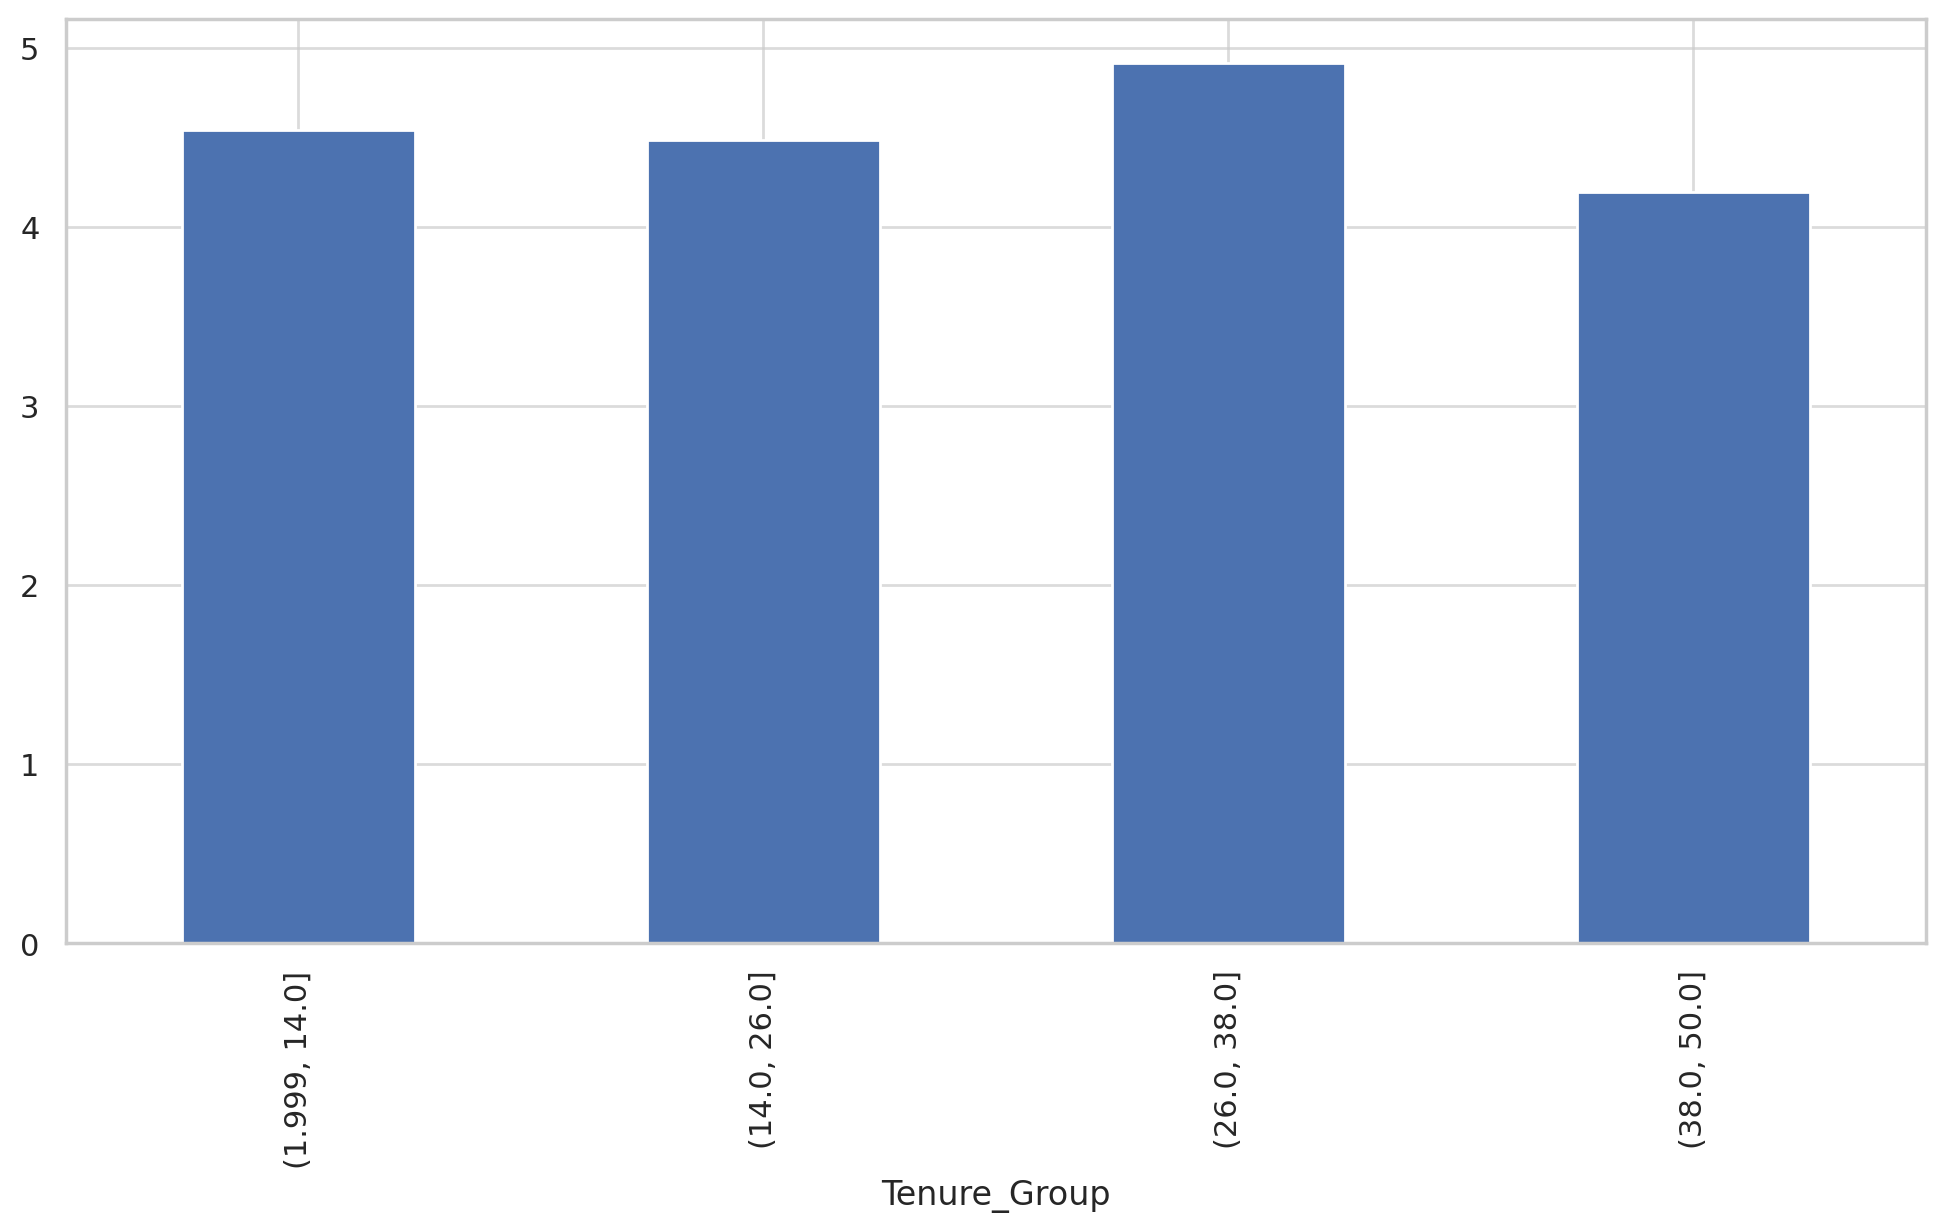

In [19]:
customers['Tenure_Group'] = pd.qcut(customers['Tenure_Months'], 4)
tenure_data = data.merge(customers[['CustomerID', 'Tenure_Group']], on='CustomerID')
tenure_freq = tenure_data.groupby(['Tenure_Group', 'CustomerID'])['Transaction_ID'].nunique().reset_index()
tenure_freq.groupby('Tenure_Group')['Transaction_ID'].mean().plot(kind='bar')

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Lower charges correlate with increased orders.

/home/sandbox/.local/lib/python3.11/site-packages/seaborn/relational.py:658: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


<AxesSubplot: xlabel='Delivery_Charges', ylabel='Quantity'>

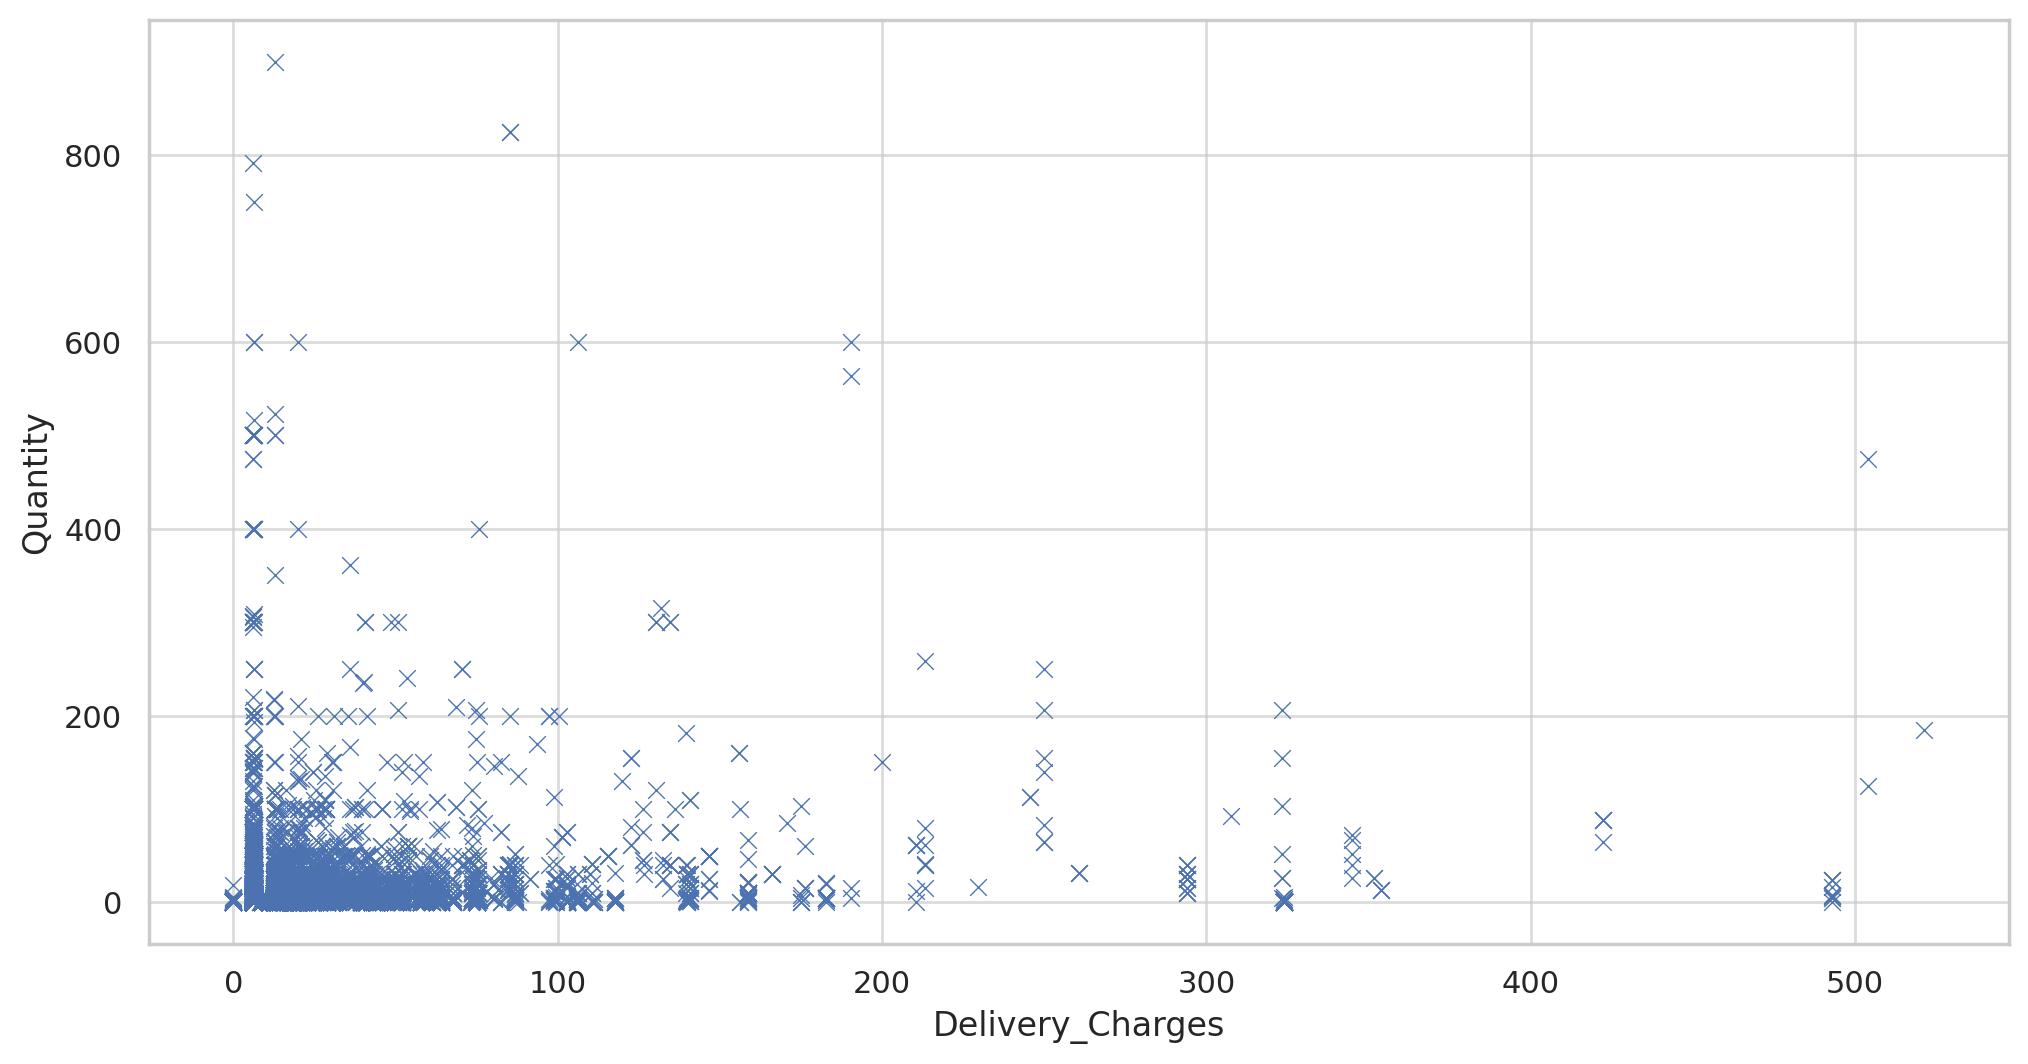

In [20]:
sns.scatterplot(x='Delivery_Charges', y='Quantity', data=data)

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Higher taxes slightly reduce order value.

<AxesSubplot: xlabel='GST', ylabel='Avg_Price'>

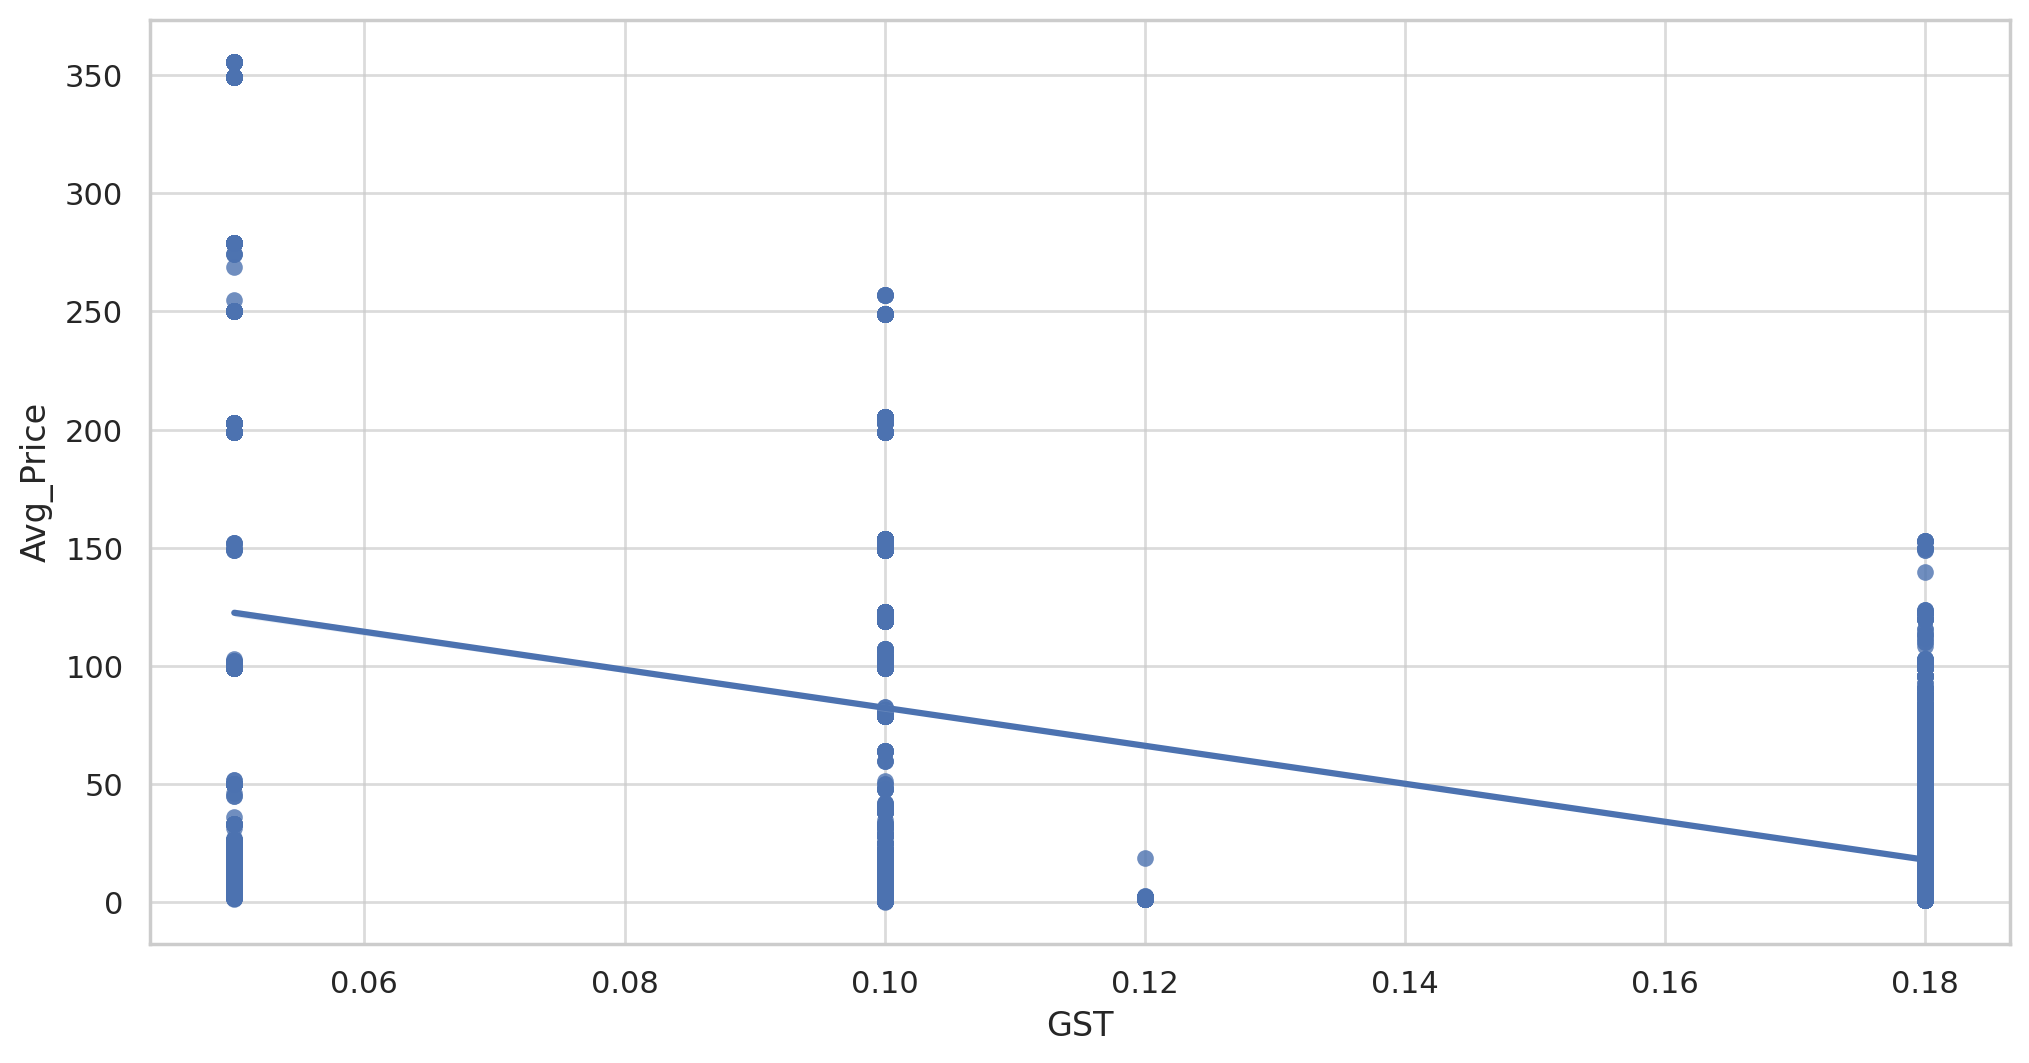

In [21]:
# Requires joining tax info
data = data.merge(tax_amount, on='Product_Category', how='left')
sns.regplot(x='GST', y='Avg_Price', data=data)

### QQ1: Identify the months with the highest and lowest acquisition rates. What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

**Answer:** Apparel peaks in winter, lifestyle peaks in summer.

<AxesSubplot: xlabel='Month'>

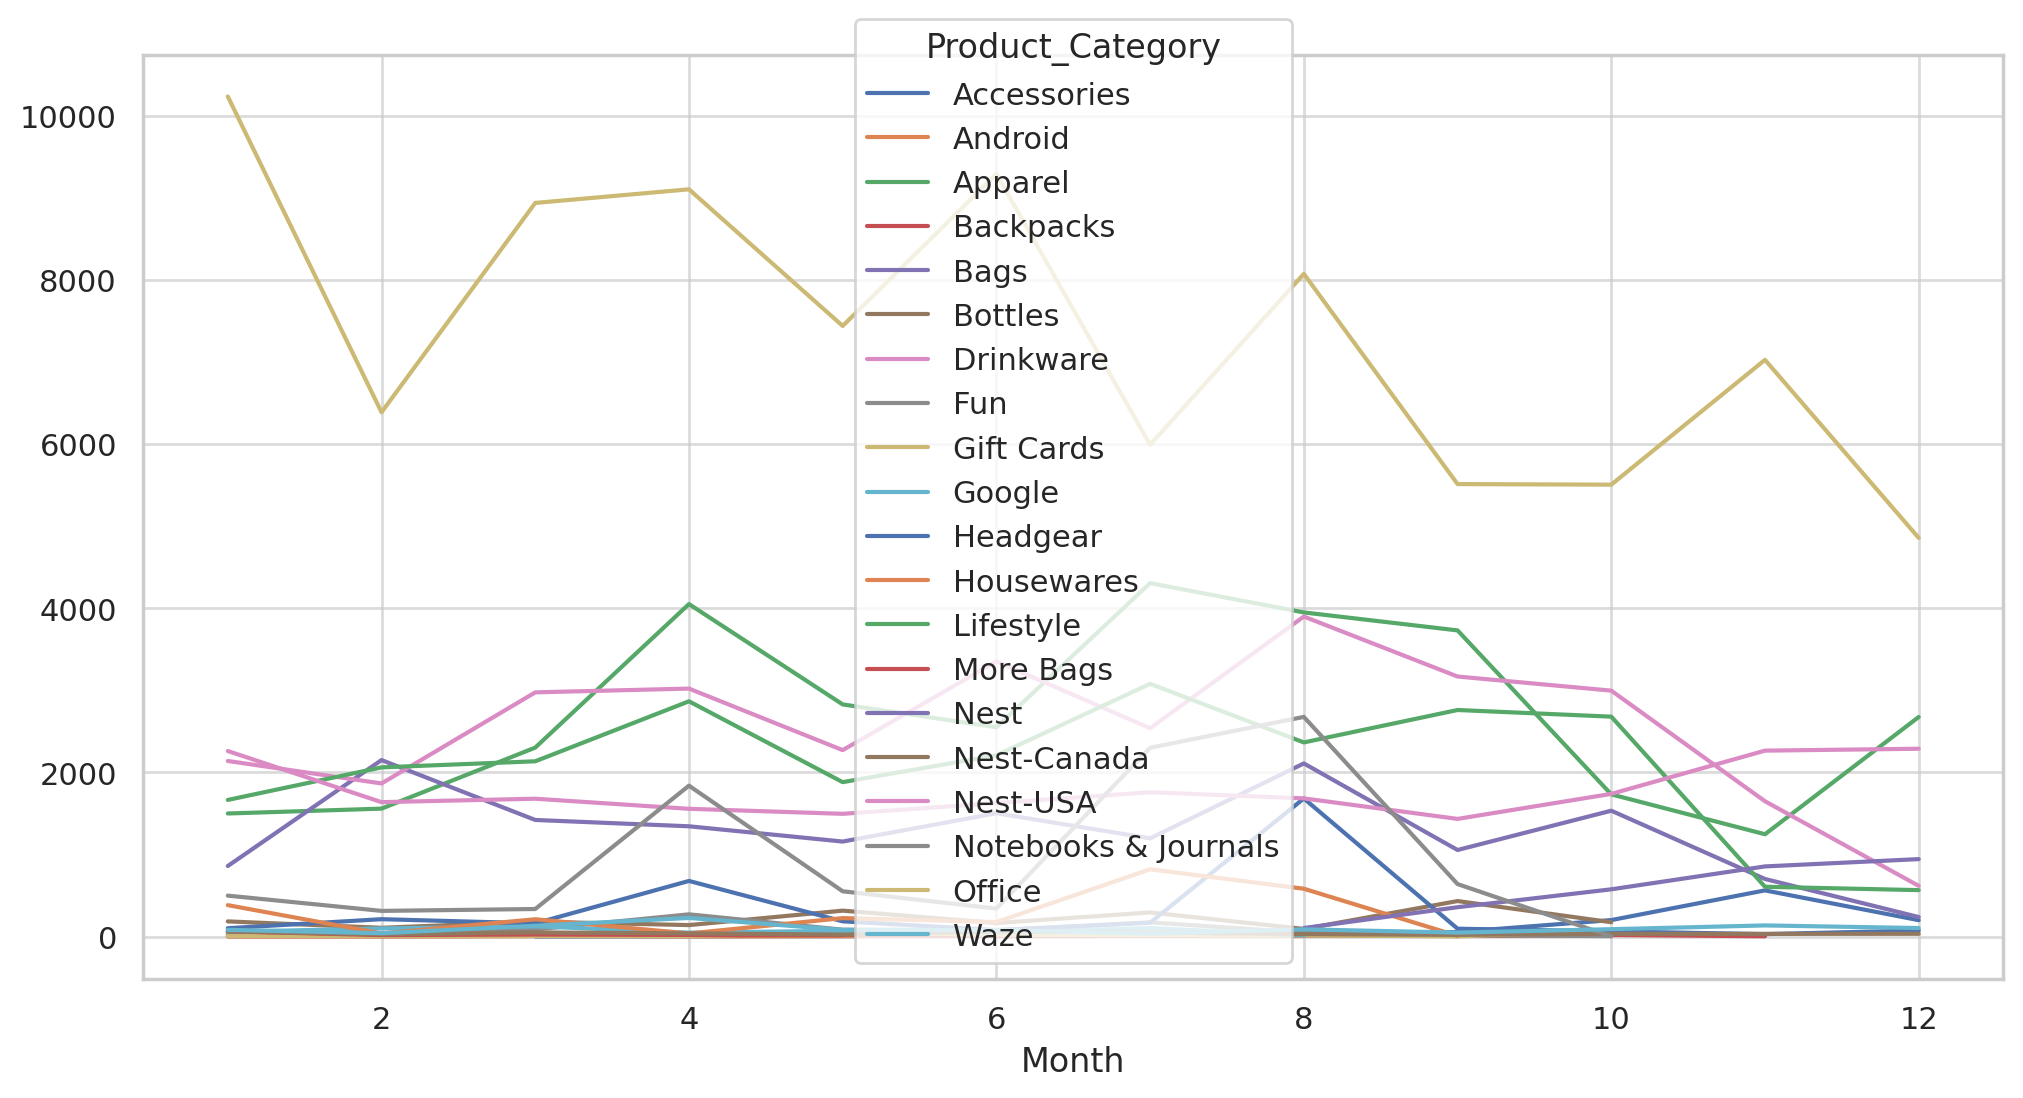

In [22]:
data['Month'] = data['Transaction_Date'].dt.month
seasonal_sales = data.groupby(['Month', 'Product_Category'])['Quantity'].sum().reset_index()
seasonal_sales.pivot(index='Month', columns='Product_Category', values='Quantity').plot()

### QQ2: Analyze the data to determine if certain months consistently show higher or lower acquisition rates. How can the company capitalize on high-performing months and improve performance during slower periods?

**Answer:** Weekends have lower sales.

<AxesSubplot: xlabel='DayOfWeek'>

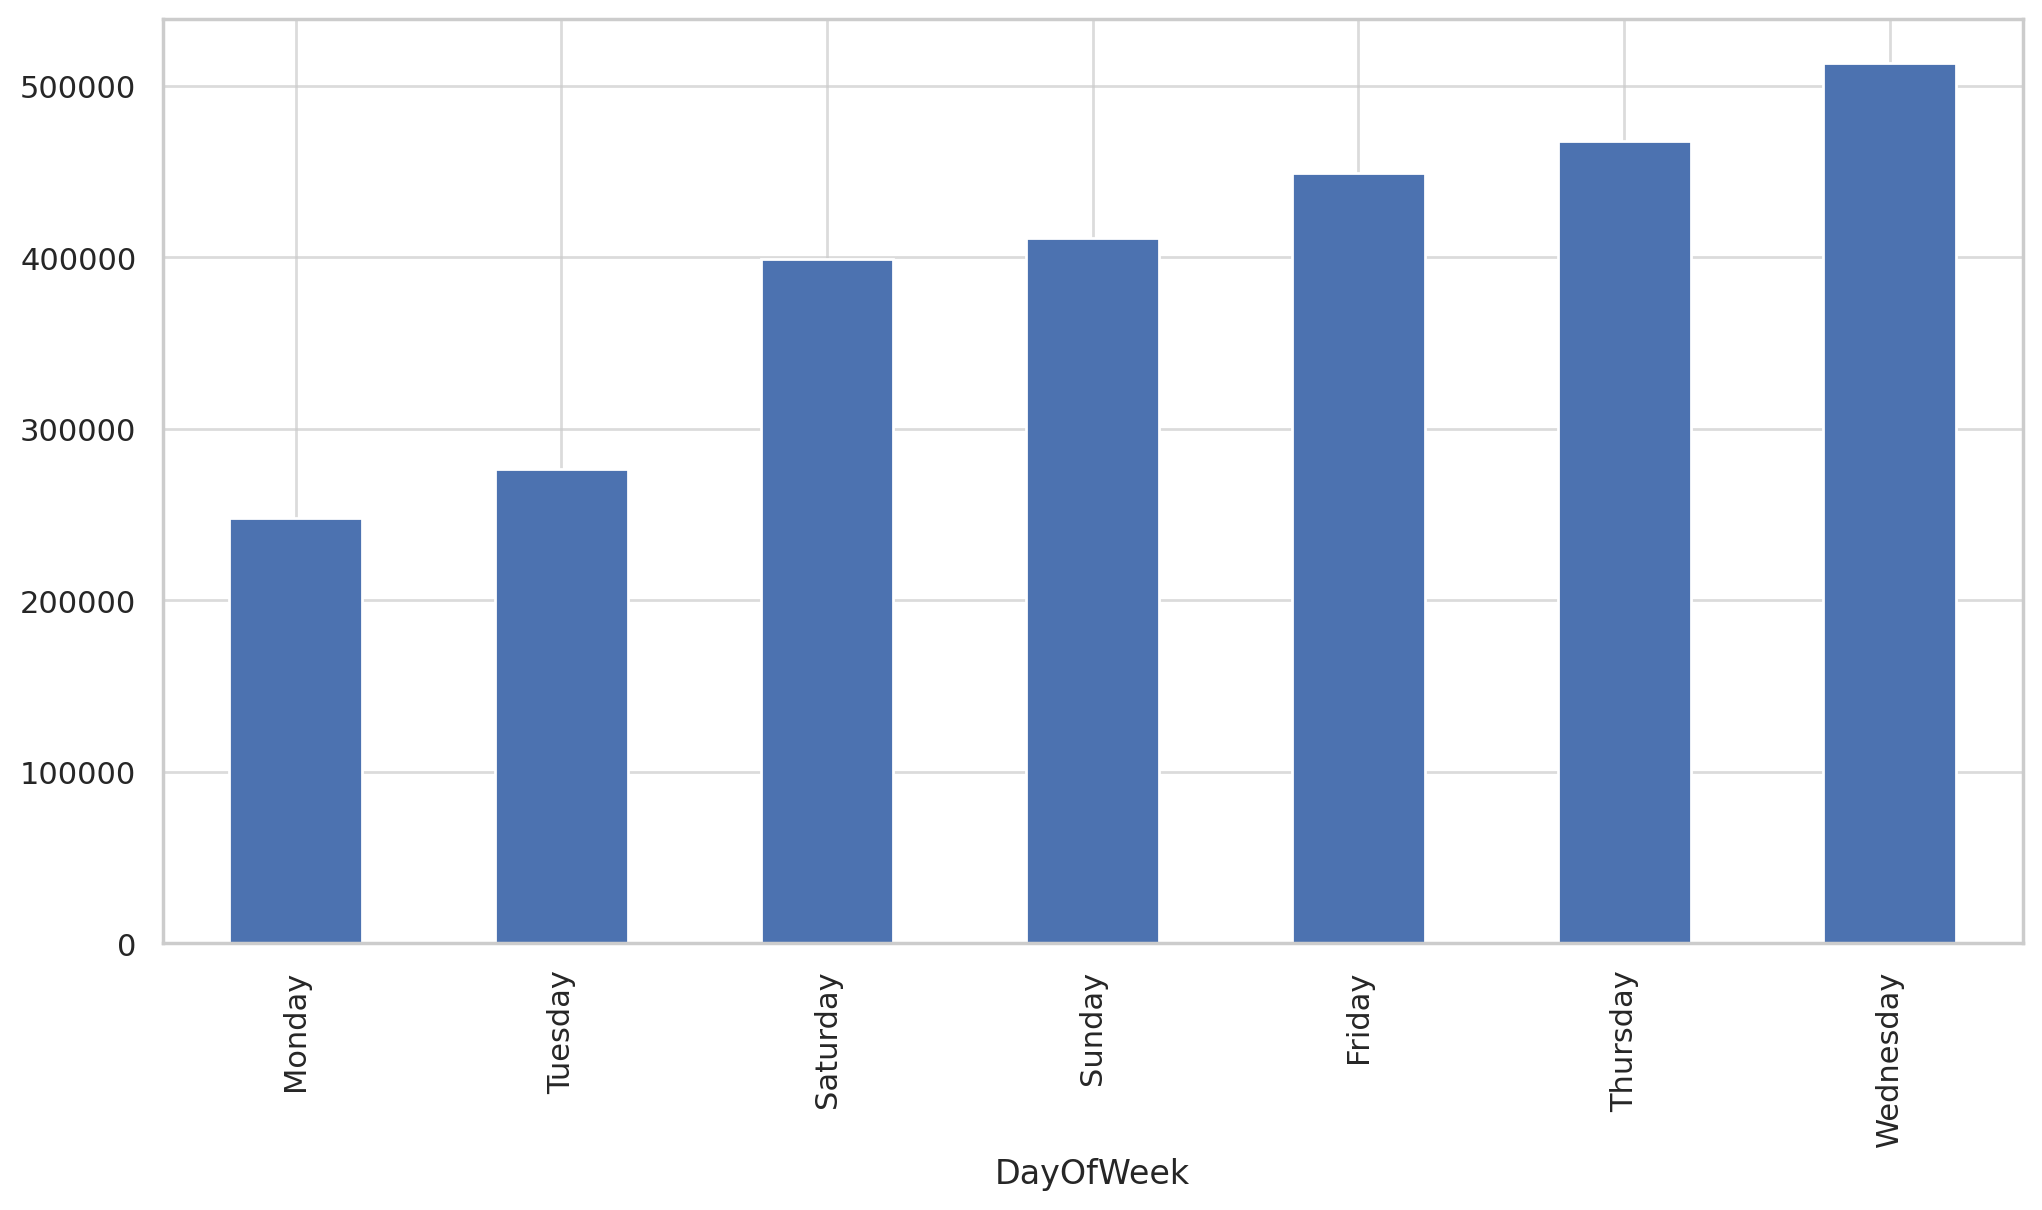

In [23]:
data['DayOfWeek'] = data['Transaction_Date'].dt.day_name()
daily_sales = data.groupby('DayOfWeek')['Avg_Price'].sum().sort_values()
daily_sales.plot(kind='bar')